# Investigate binned maps 

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'

In [2]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def Gauss_2D_fromgrid(beam,concat,find,chind):
    xes = np.ndarray.flatten(beam.x_centers_grid[:,:,0])
    yes = np.ndarray.flatten(beam.y_centers_grid[:,:,0])
    Gfit = np.zeros(beam.V_LC_operation[:,:,0,0].shape)
    P = [1.0,0.0,concat.G_popt[chind,find,2],0.0,
        concat.G_popt[chind,find,4],concat.G_popt[chind,find,5]]
    #fits = fu.Gauss_2d_LC_func(concat.G_popt[chind,find,:-1],xes,yes)
    fits = fu.Gauss_2d_LC_func(P,xes,yes)
    reshapefits = fits.reshape((beam.x_centers_grid[:,:,0].shape))
    return reshapefits

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

In [3]:
## Read in Yaml file for info per flight:
with open('/home/ln267/newburghlabdrone/analysis/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
print(pcklarr)

## Define anything I want to keep common
dotsize=1
res = 500
LX,LY = np.meshgrid(np.linspace(-100,100,res), np.linspace(-100,100,res))
X = np.arange(-100,100,2.0,dtype='float64')
Y = np.arange(-100,100,2.0,dtype='float64')

# WHICH FREQUENCY IS MY DEFAULT:
find=900#570#800#900
f_intern = 1
print(freqs[find])
print(flights)


# Define colormap for this nb:
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)


sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# values for masks:
high = 20 # inner mask, 20 for large flights
low = -20 # inner mask, 20 for large flights
maskin = high # annulus mask, set equal to high
maskout = 40 # annulus mask, 50 for large flights

nss = np.arange(0.1,3.0,0.001) # this defines the range of amplitudes for variance checking

['FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl'
 'FLY534_20210826T185621Z_ver_20230412T212230_concat.pkl'
 'FLY535_20210826T192056Z_ver_20230412T213957_concat.pkl'
 'FLY536_20210826T195003Z_ver_20230413T105756_concat.pkl'
 'FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl'
 'FLY619_20211021T185805Z_ver_20230412T222348_concat.pkl'
 'FLY620_20211021T192212Z_ver_20230412T224334_concat.pkl'
 'FLY623_20211021T203206Z_ver_20230412T230820_concat.pkl'
 'FLY625_20211021T214028Z_ver_20230412T232657_concat.pkl'
 'FLY646_20211022T183659Z_ver_20230412T234457_concat.pkl'
 'FLY647_20211022T185749Z_ver_20230413T000337_concat.pkl'
 'FLY648_20211022T191922Z_ver_20230413T002159_concat.pkl'
 'FLY649_20211022T194308Z_ver_20230413T003934_concat.pkl']
448.4375
['533', '534', '535', '536', '618', '619', '620', '623', '625', '646', '647', '648', '649']


In [4]:
fly1 = '533'
fly2 = '618'


## Playing around with the map class first ###


533 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 36
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY533_20210826T182904Z_ver_20230412T211305_concat.pkl'>


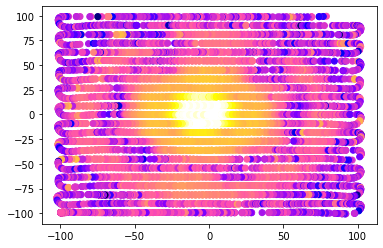

start of big ass loop is: 2023-04-28 13:12:49.839436
end of bigass loop is: 2023-04-28 13:12:54.808073   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:270: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)
<ipython-input-5-2d44efd33550>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],
<ipython-input-5-2d44efd33550>:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(-1*sz,sz)
<ipython-input-5-2d44efd33550>:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-1*sz,sz)


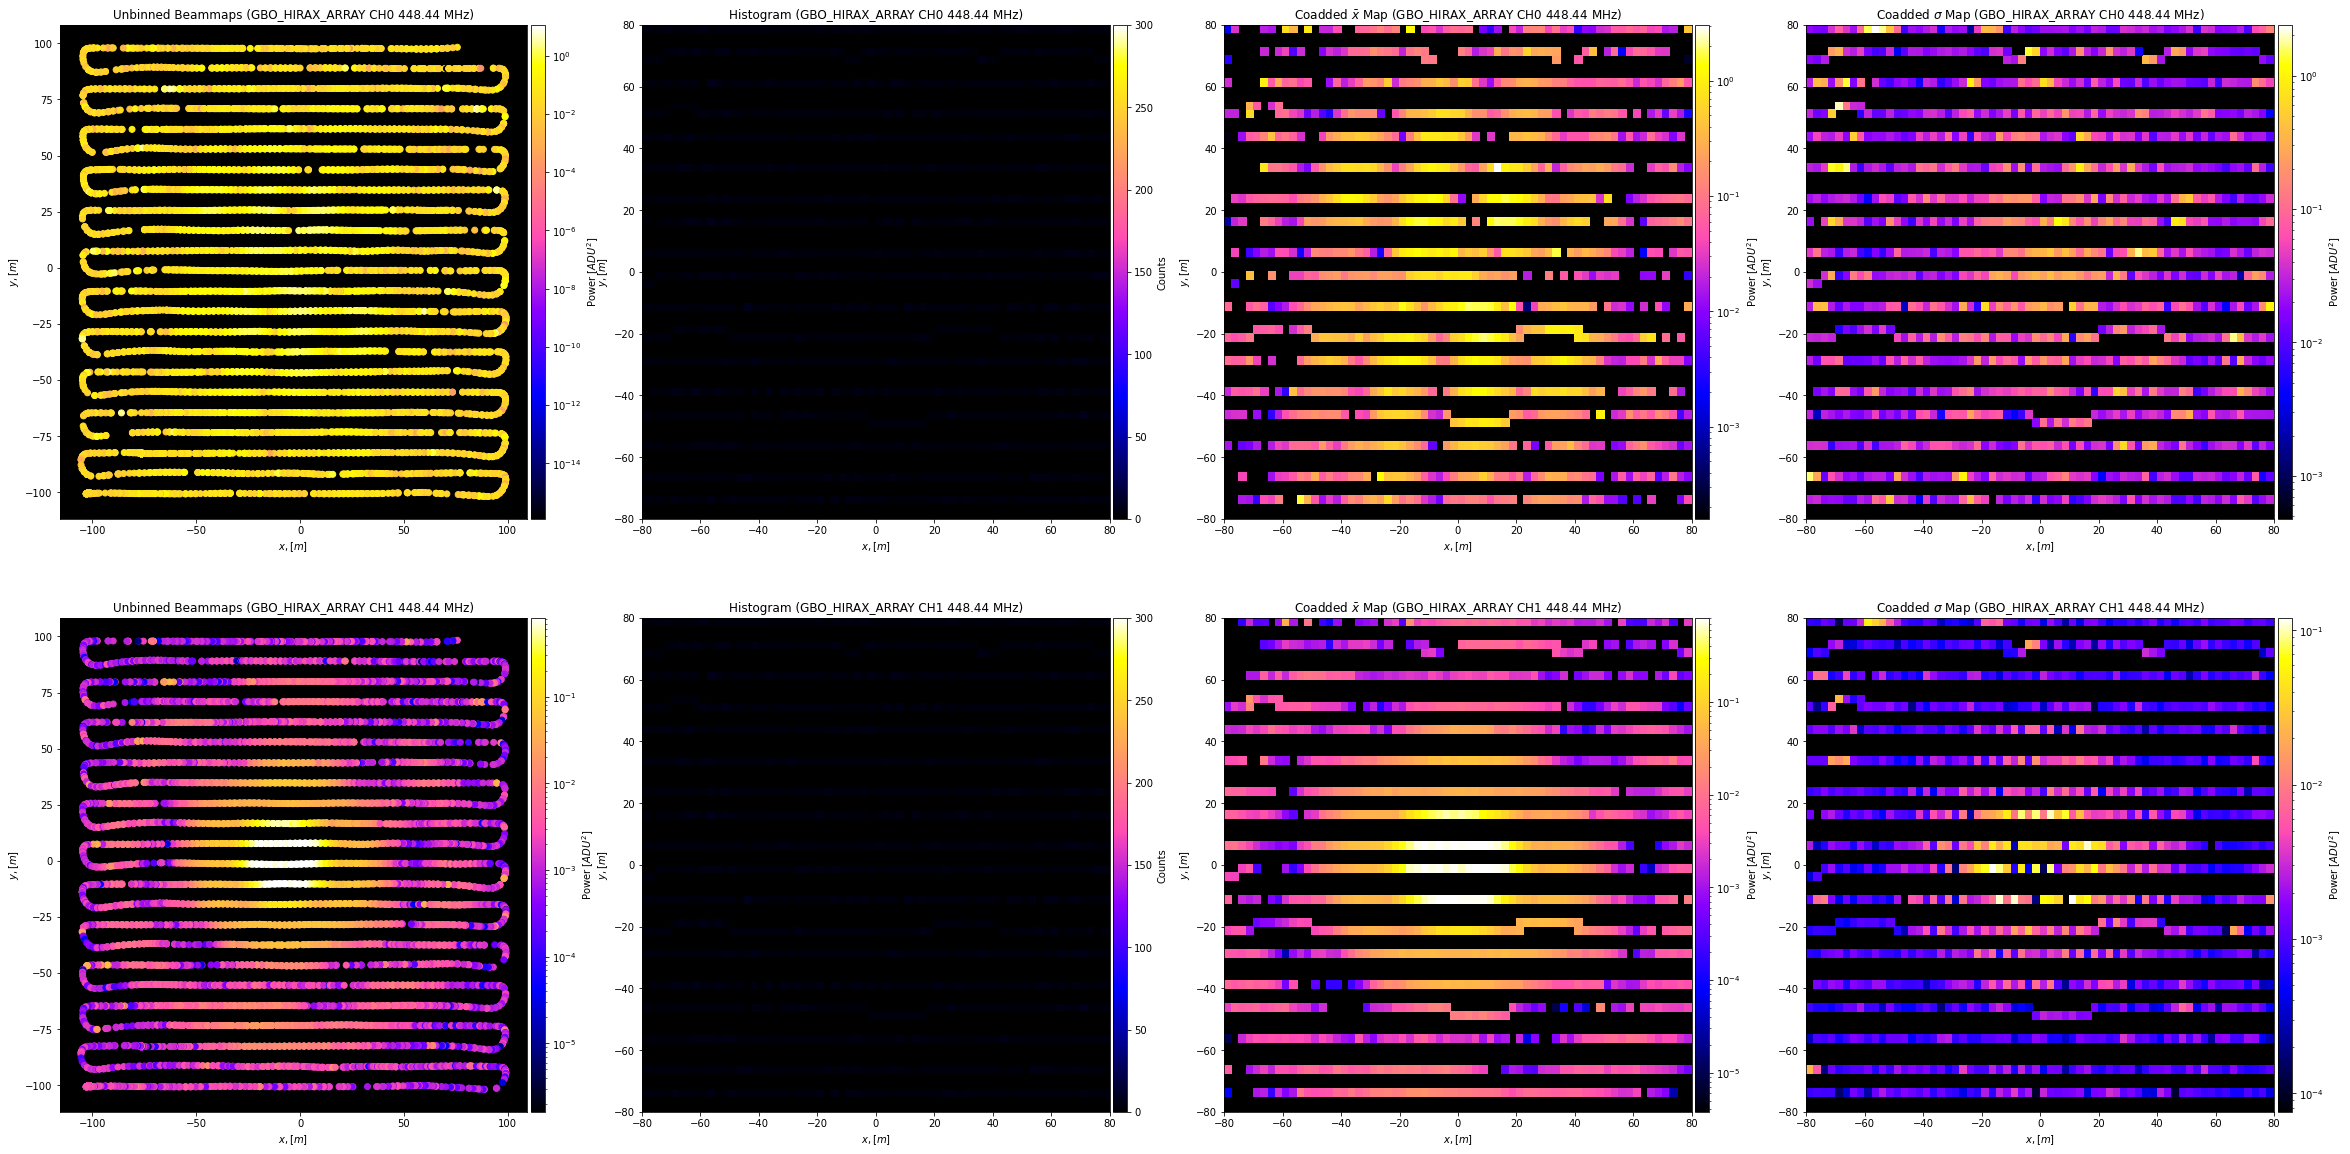

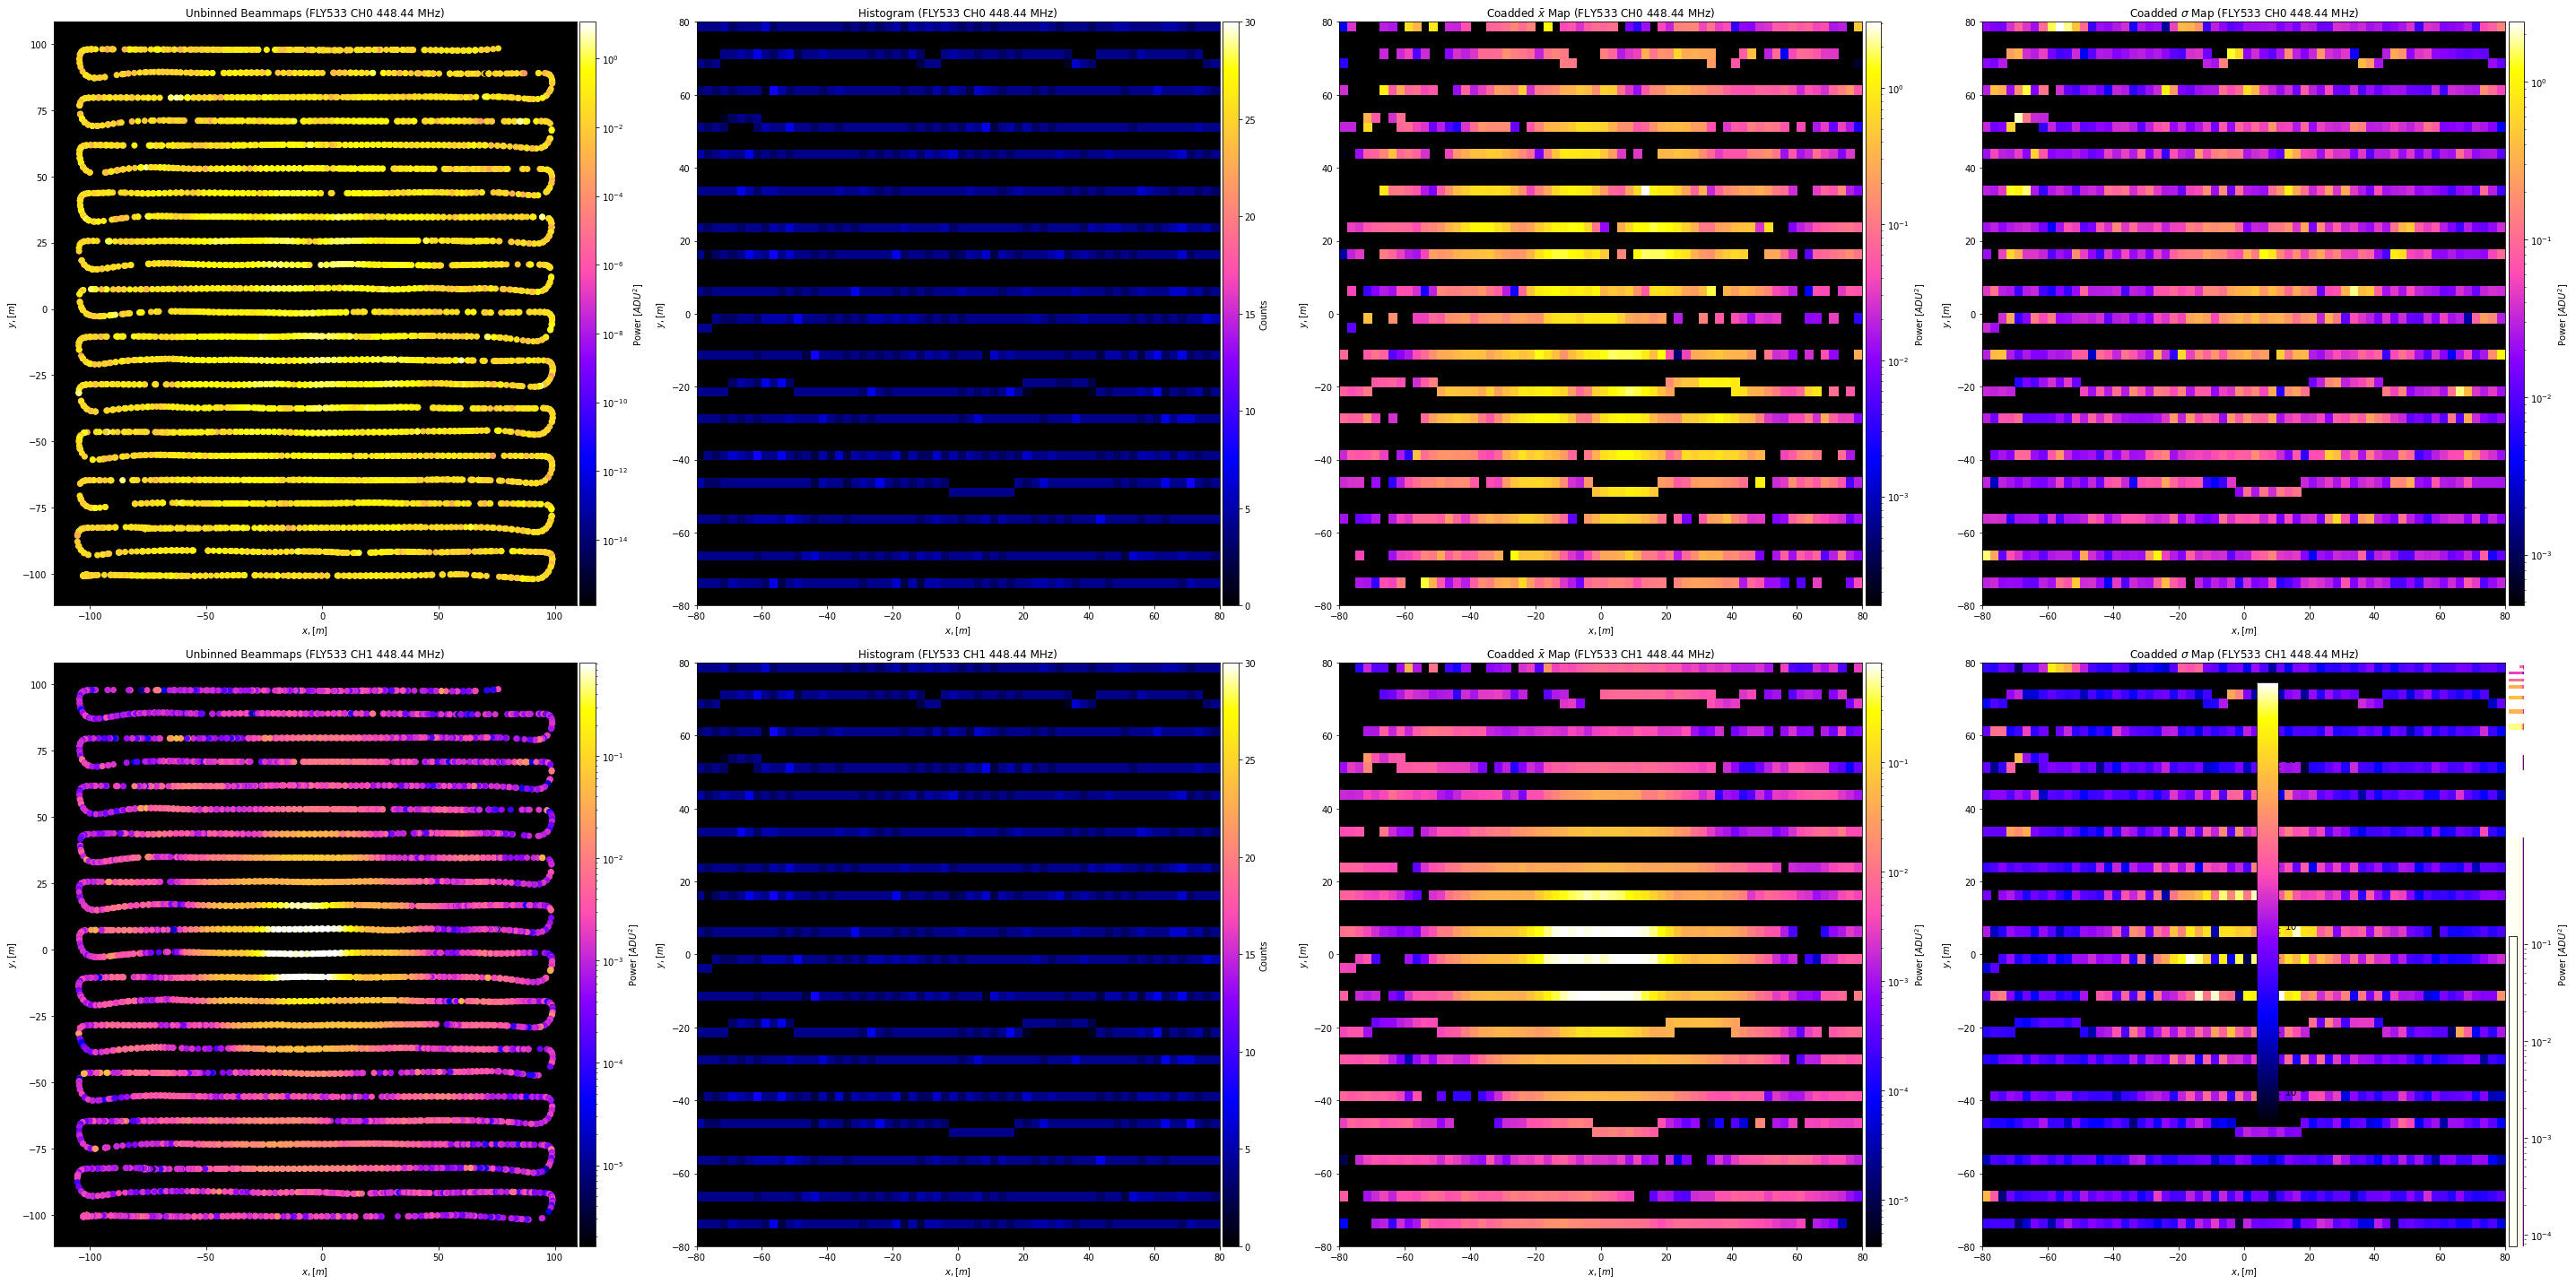

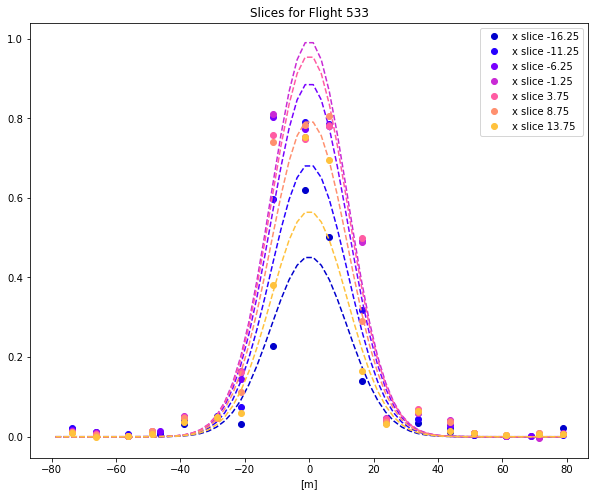

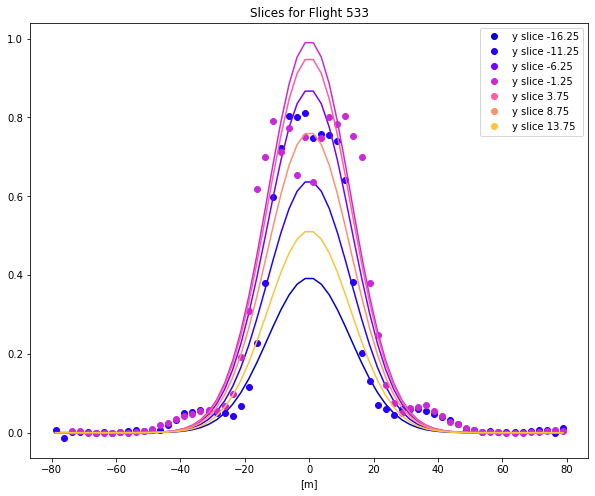

In [5]:
# Flight 1:: 

# Get info
pol, pols, cpols, attn, fi = get_flightinfo(fly1)
print(fly1,pol,pols,cpols, attn)
chind = pols[0]

concytest=[glob.glob(pckldir+'*'+fly1+'*')[0] for x in flights]
print(concytest[fi])

with open(glob.glob(pckldir+'*'+fly1+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on    

# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

beam1=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find-1,find+1,1],f_index=find)

plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],
               beam1.V_LC_operation[:,:,f_intern,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.colorbar()
plt.show()

fit = Gauss_2D_fromgrid(beam1,concattest1,find,chind)
#plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],10*np.log10(fit))
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    colx = get_slice(beam1,beam1.V_LC_mean[:,:,f_intern,chind,0],xx,'x')
    plt.plot(beam1.y_centers_grid[:,colx,0],beam1.V_LC_mean[colx,:,f_intern,chind,0].T,'o',color=cmap(norm(xx)),label='x slice '+str(beam1.x_centers_grid[0,colx,0]))
    plt.plot(beam1.y_centers_grid[:,colx,chind],fit[:,colx],color=cmap(norm(xx)),linestyle='--')#,label='x slice '+str(xx))
plt.title('Slices for Flight '+str(fly1))
plt.xlabel('[m]')
plt.legend()
fig = plt.gcf()
fig.savefig('Flight_'+str(fly1)+'_xslices.png')
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    coly = get_slice(beam1,beam1.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
    plt.plot(beam1.x_centers_grid[coly,:,0],beam1.V_LC_mean[:,coly,f_intern,chind,0].T,'o',color=cmap(norm(xx)),label='y slice '+str(beam1.y_centers_grid[coly,0,0]))
    plt.plot(beam1.x_centers_grid[coly,:,chind],fit[coly,:],color=cmap(norm(xx)))#,label='y slice '+str(xx))
plt.title('Slices for Flight '+str(fly1))
plt.xlabel('[m]')
plt.legend()
fig = plt.gcf()
fig.savefig('Flight_'+str(fly1)+'_yslices.png')
plt.show()


618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230412T220022_concat.pkl'>


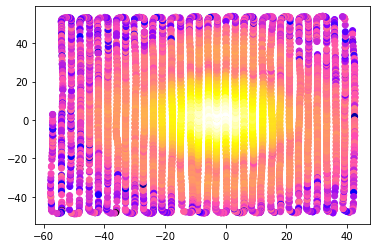

start of big ass loop is: 2023-04-28 13:13:04.811485
end of bigass loop is: 2023-04-28 13:13:08.644816   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:270: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)
<ipython-input-6-4d70e1f93e42>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],10*np.log10(fit))


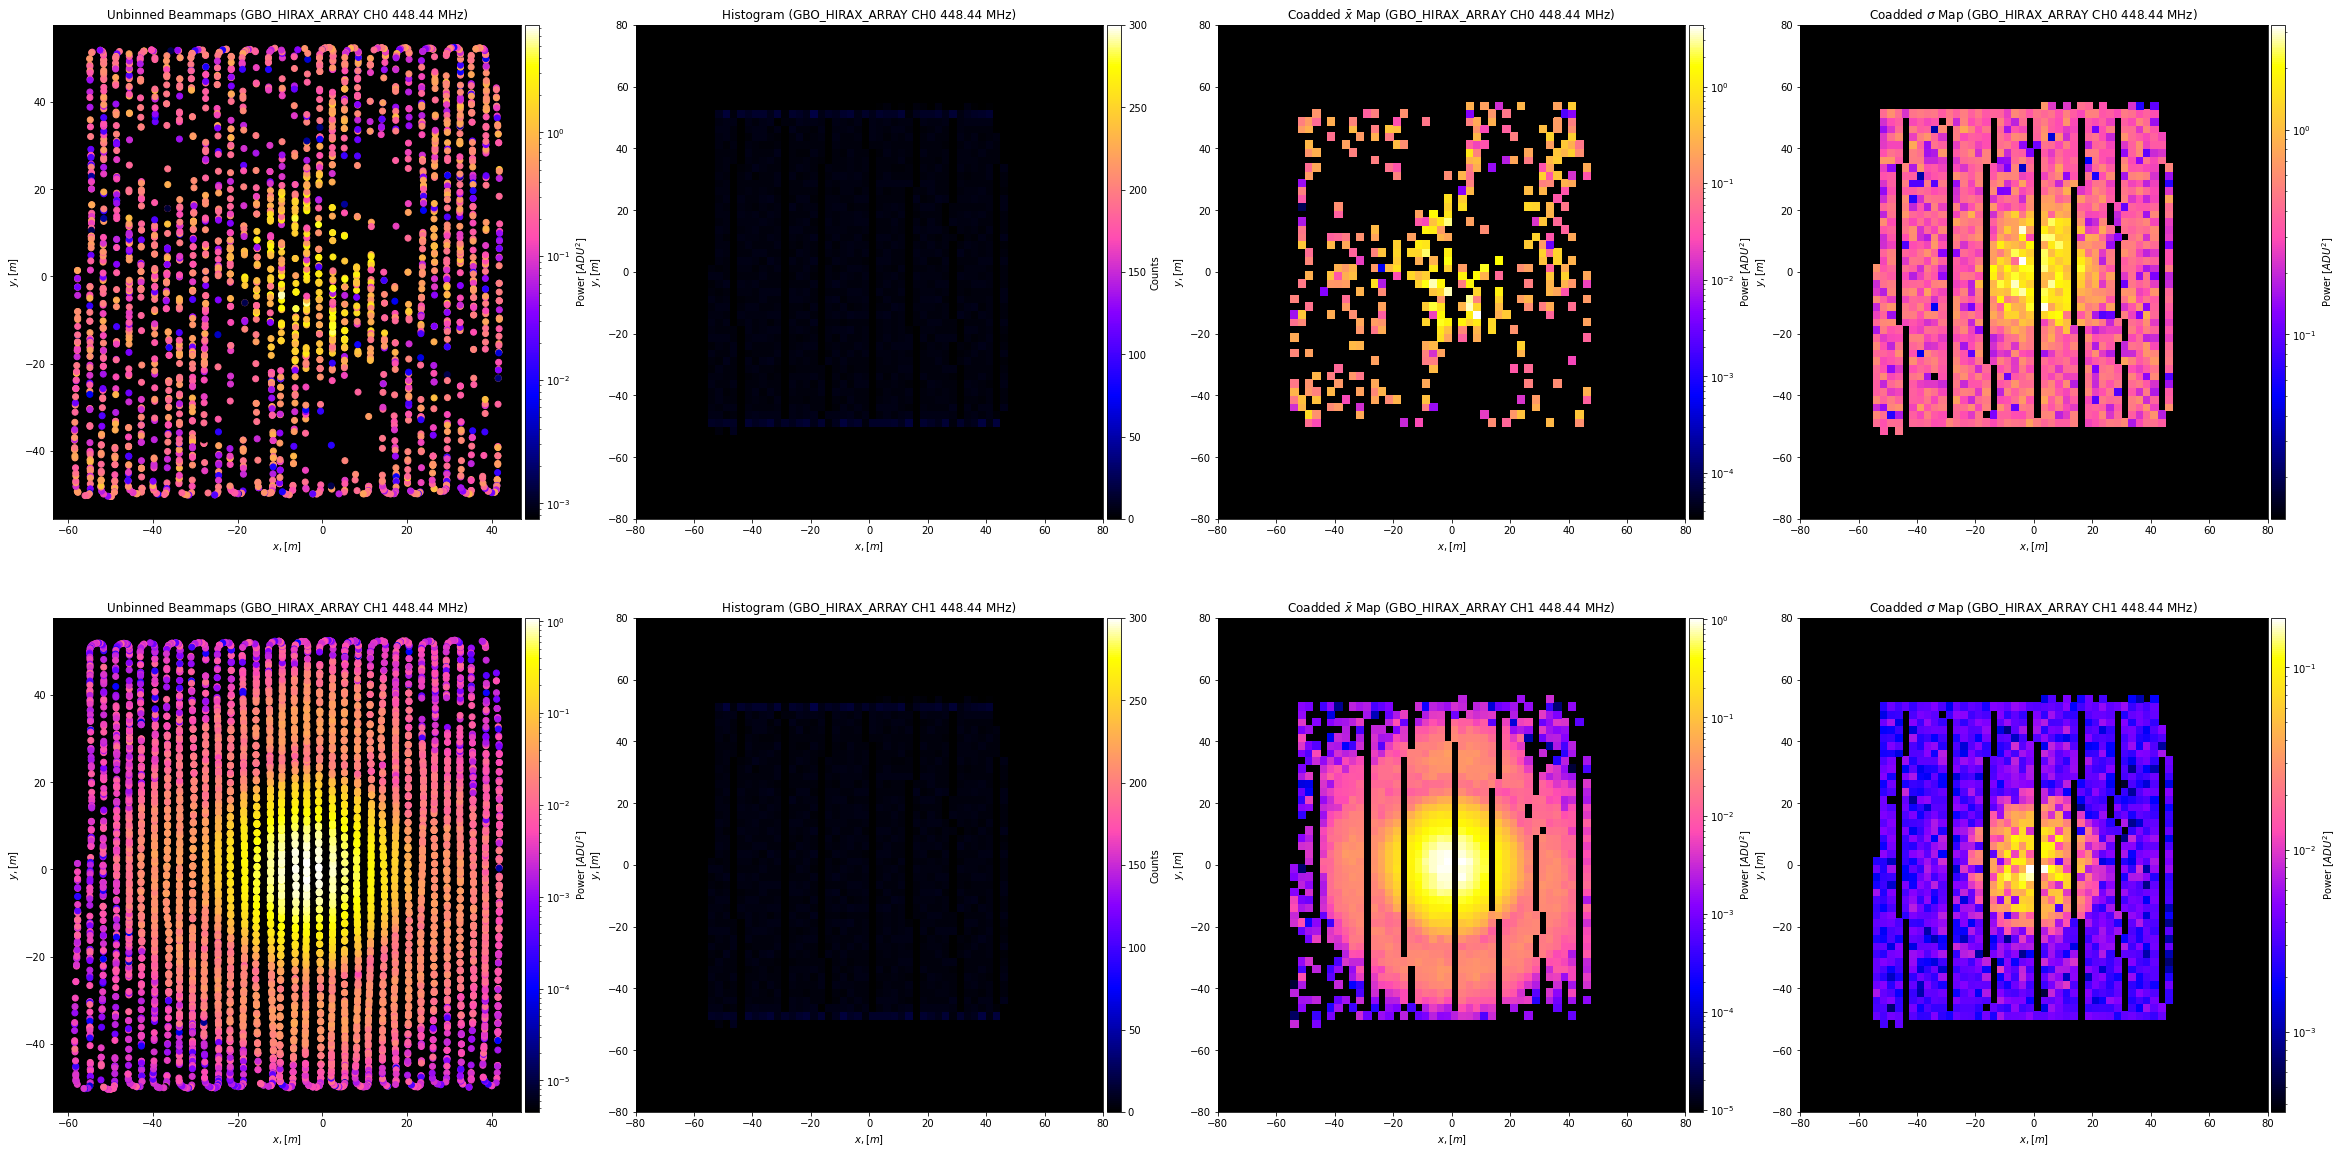

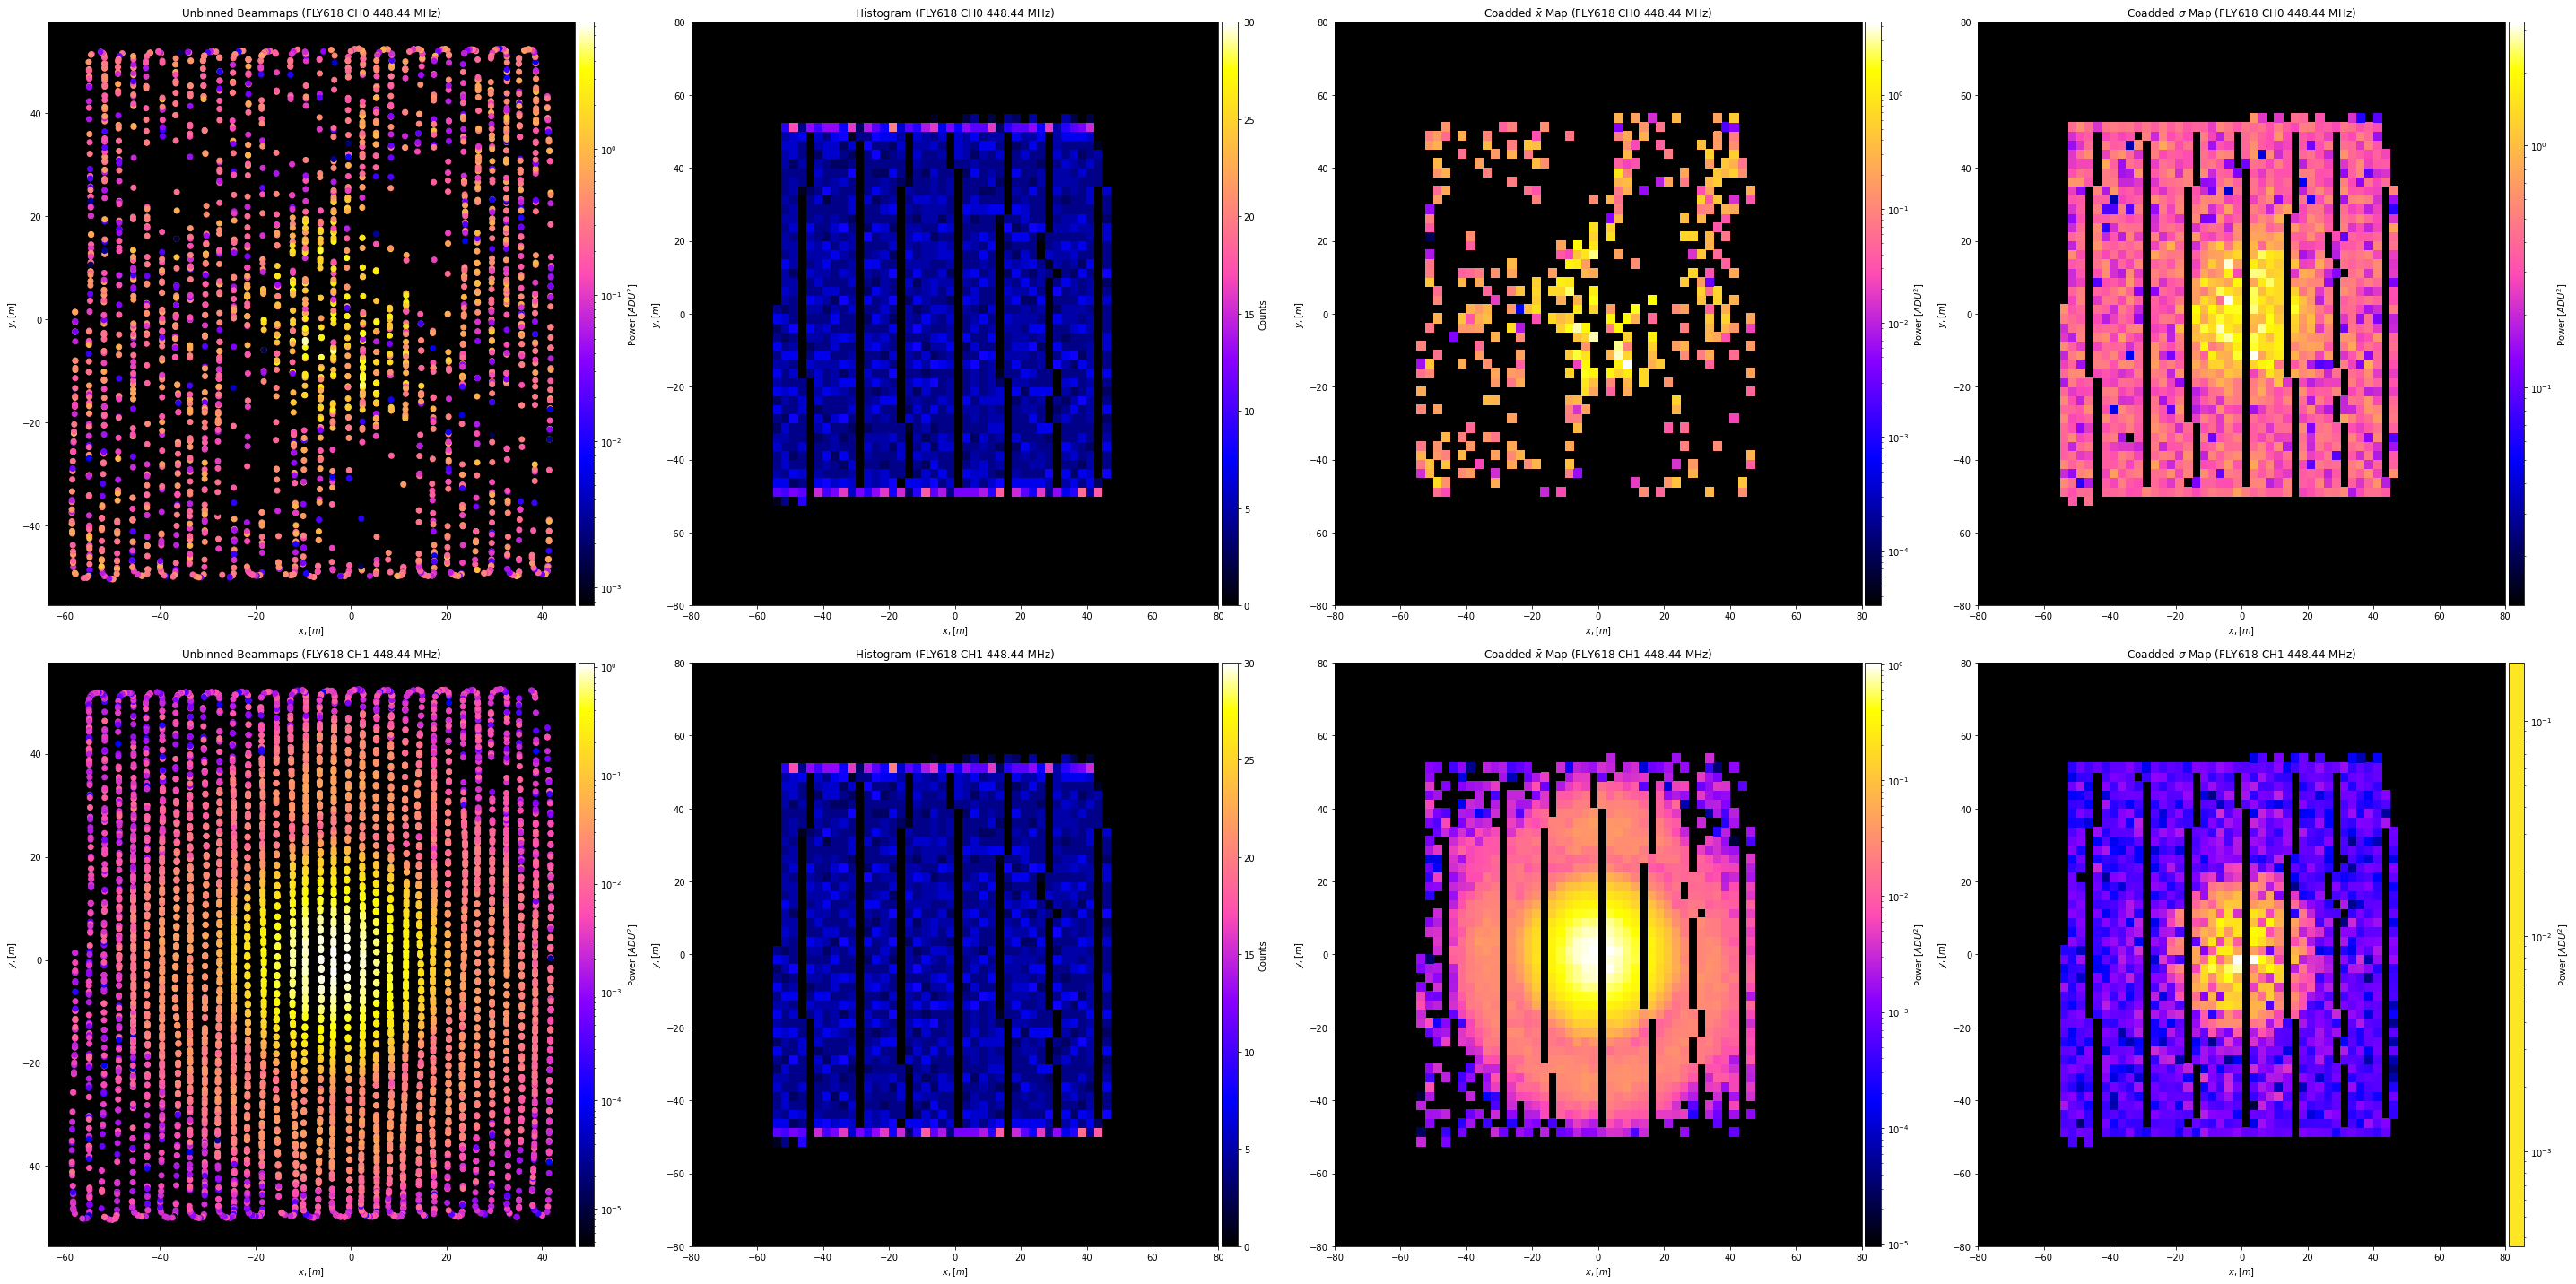

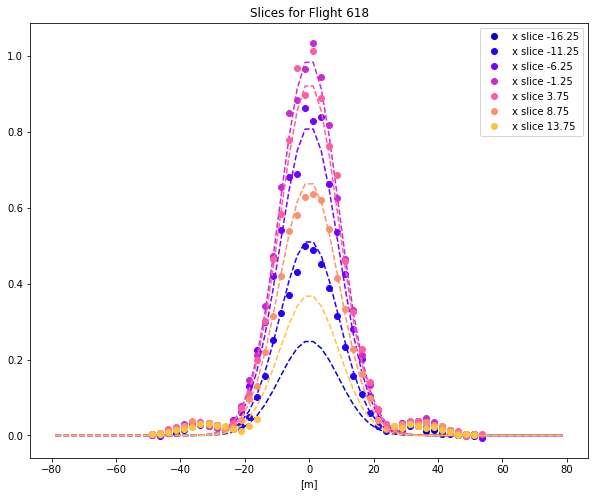

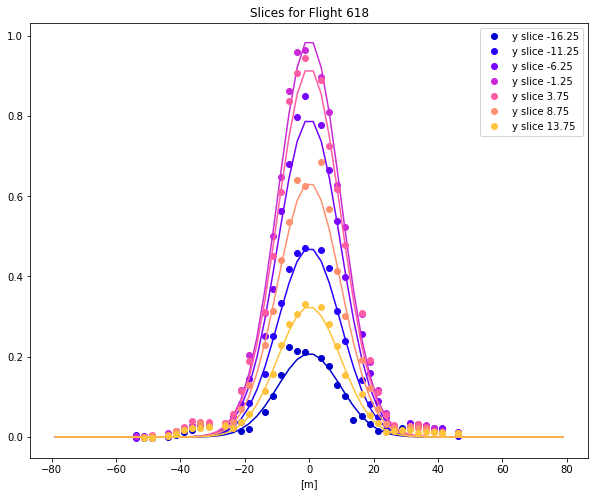

In [6]:
# Same as above for flight #2 

pol, pols, cpols, attn, fi = get_flightinfo(fly2)
print(fly2,pol,pols,cpols, attn)
chind = pols[0]

concytest=[glob.glob(pckldir+'*'+fly2+'*')[0] for x in flights]
print(concytest[fi])

with open(glob.glob(pckldir+'*'+fly2+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest2=pickle.load(pfile)
t_cut=concattest2.inds_on    

# Scatter plot and beam map check

plt.scatter(concattest2.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concattest2.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concattest2.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

beam2=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find-1,find+1,1],f_index=find)
# Gaussian 2D:

fit = Gauss_2D_fromgrid(beam2,concattest2,find,chind)
plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],10*np.log10(fit))
plt.show()


fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    colx = get_slice(beam2,beam2.V_LC_mean[:,:,f_intern,chind,0],xx,'x')
    plt.plot(beam2.y_centers_grid[:,colx,0],beam2.V_LC_mean[colx,:,f_intern,chind,0].T,'o',color=cmap(norm(xx)),label='x slice '+str(beam2.x_centers_grid[0,colx,0]))
    plt.plot(beam2.y_centers_grid[:,colx,chind],fit[:,colx],color=cmap(norm(xx)),linestyle='--')#,label='x slice '+str(xx))
plt.title('Slices for Flight '+str(fly2))
plt.xlabel('[m]')
plt.legend()
fig = plt.gcf()
fig.savefig('Flight_'+str(fly2)+'_xslices.png')
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    coly = get_slice(beam2,beam2.V_LC_mean[:,:,f_intern,chind,0],xx,'y')
    plt.plot(beam2.x_centers_grid[coly,:,0],beam2.V_LC_mean[:,coly,f_intern,chind,0].T,'o',color=cmap(norm(xx)),label='y slice '+str(beam2.y_centers_grid[coly,0,0]))
    plt.plot(beam2.x_centers_grid[coly,:,chind],fit[coly,:],color=cmap(norm(xx)))#,label='y slice '+str(xx))
plt.title('Slices for Flight '+str(fly2))
plt.xlabel('[m]')
plt.legend()
fig = plt.gcf()
fig.savefig('Flight_'+str(fly2)+'_yslices.png')
plt.show()

# Investigate map differences

<ipython-input-7-3113f0d30b6e>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],


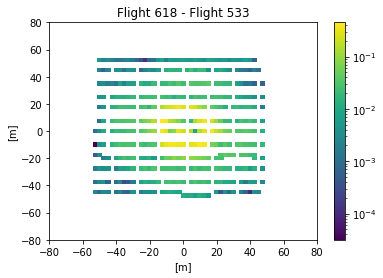

In [7]:
# look at differences

diff = get_beam_diff(beam2.V_LC_mean[:,:,f_intern,chind,0], beam1.V_LC_mean[:,:,f_intern,chind,0],1.0)

plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],
               np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Flight '+str(fly2)+' - Flight '+str(fly1))
plt.colorbar()
fig = plt.gcf()
fig.savefig('Flight_'+str(fly2)+'-Flight_'+str(fly1)+'_Gnorm_map.png')
plt.show()


In [8]:
## Create masks:

# Mask inner region
thingyx = np.ma.masked_inside(beam1.x_centers_grid[:,:,chind], low, high, copy=True)
thingyy = np.ma.masked_inside(beam1.y_centers_grid[:,:,chind], low, high, copy=True)
inner_mask = np.logical_and(thingyx.mask,thingyy.mask)


# Mask outer region
outer_mask = np.logical_not(inner_mask)


# Mask annulus

thingyx = np.ma.masked_inside(beam1.x_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
thingyy = np.ma.masked_inside(beam1.y_centers_grid[:,:,chind], -1*maskin, maskin, copy=True)
inner_mask = np.logical_and(thingyx.mask,thingyy.mask)

thingyx = np.ma.masked_inside(beam1.x_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingyy = np.ma.masked_inside(beam1.y_centers_grid[:,:,chind], -1*maskout, maskout, copy=True)
thingy = np.logical_and(thingyx.mask,thingyy.mask)
outer_mask = np.logical_not(thingy)

full_mask = np.logical_or(inner_mask,outer_mask)


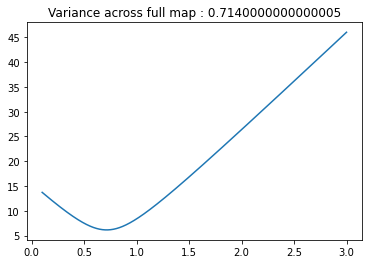

<ipython-input-9-b35fbf8bdb94>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')


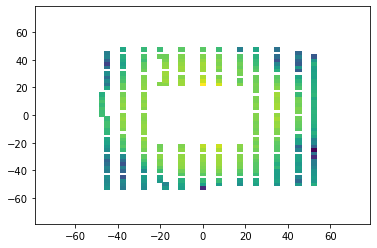

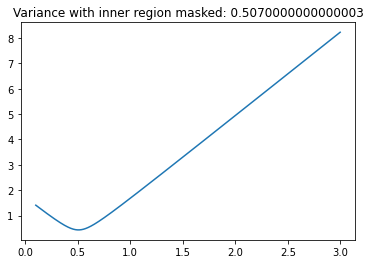

<ipython-input-9-b35fbf8bdb94>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')


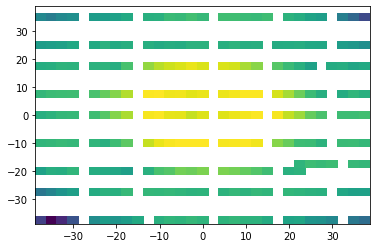

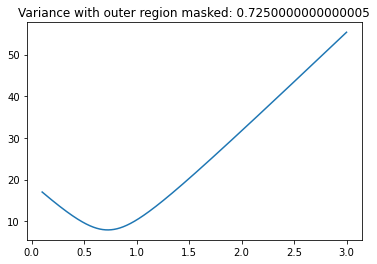

<ipython-input-9-b35fbf8bdb94>:76: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')


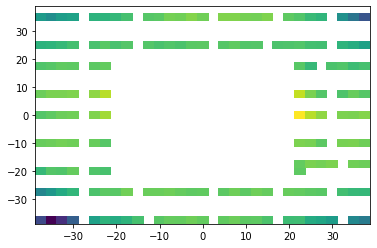

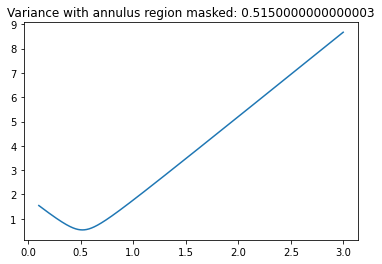

Best norm from variance across full map : 0.7140000000000005
Best norm from variance with inner region masked: 0.5070000000000003
Best norm from variance with outer region masked: 0.7250000000000005
Best norm from variance with annulus region masked: 0.5150000000000003


In [9]:
# Find relative normalization that minimizes the 100*variance

#print(100*np.nanvar(diff_flat),100*np.nanstd(diff_flat),100*np.nanmedian(diff_flat),100*np.nanmean(diff_flat**2))

std100 = np.zeros([len(nss)])

# No mask at all
for i in np.arange(0,len(nss)):
    ns = nss[i]
    diffn = diff = get_beam_diff(beam2.V_LC_mean[:,:,f_intern,chind,0], beam1.V_LC_mean[:,:,f_intern,chind,0],ns)
    diff_flat = np.ndarray.flatten(diffn)
    std100[i] = 100*np.nanstd(diff_flat)
mm = np.argmin(std100)
n_full = nss[mm]

plt.plot(nss,std100)
plt.title('Variance across full map : '+str(n_full))
plt.show()


# mask inner region
std100 = np.zeros([len(nss)])
new_x = np.ma.masked_where(inner_mask, beam1.x_centers_grid[:,:,chind])
new_y = np.ma.masked_where(inner_mask, beam1.y_centers_grid[:,:,chind])
new_d = np.ma.masked_where(inner_mask, diff.T)

plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')
plt.show()

for i in np.arange(0,len(nss)):
    ns = nss[i]
    diffn = diff = get_beam_diff(beam2.V_LC_mean[:,:,f_intern,chind,0], beam1.V_LC_mean[:,:,f_intern,chind,0],ns)
    new_d = np.ma.masked_where(inner_mask, diffn)
    diff_flat = np.ndarray.flatten(new_d)
    std100[i] = 100*np.nanstd(diff_flat)
mm = np.argmin(std100)
n_inner = nss[mm]


plt.plot(nss,std100)
plt.title('Variance with inner region masked: '+str(n_inner))
plt.show()



# Mask outside region
new_x = np.ma.masked_where(outer_mask, beam1.x_centers_grid[:,:,chind])
new_y = np.ma.masked_where(outer_mask, beam1.y_centers_grid[:,:,chind])
new_d = np.ma.masked_where(outer_mask, diff)


plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')
plt.show()

std100 = np.zeros([len(nss)])
for i in np.arange(0,len(nss)):
    ns = nss[i]
    diffn = diff = get_beam_diff(beam2.V_LC_mean[:,:,f_intern,chind,0], beam1.V_LC_mean[:,:,f_intern,chind,0],ns)
    new_d = np.ma.masked_where(outer_mask, diffn)
    diff_flat = np.ndarray.flatten(new_d)
    std100[i] = 100*np.nanstd(diff_flat)
mm = np.argmin(std100)
n_outer = nss[mm]


plt.plot(nss,std100)
plt.title('Variance with outer region masked: '+str(n_outer))
plt.show()


# Mask an annulus
new_x = np.ma.masked_where(full_mask, beam1.x_centers_grid[:,:,chind])
new_y = np.ma.masked_where(full_mask, beam1.y_centers_grid[:,:,chind])
new_d = np.ma.masked_where(full_mask, diff)

plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')
plt.show()

std100 = np.zeros([len(nss)])
for i in np.arange(0,len(nss)):
    ns = nss[i]
    diffn = diff = get_beam_diff(beam2.V_LC_mean[:,:,f_intern,chind,0], beam1.V_LC_mean[:,:,f_intern,chind,0],ns)
    new_d = np.ma.masked_where(full_mask, diffn)
    diff_flat = np.ndarray.flatten(new_d)
    std100[i] = 100*np.nanstd(diff_flat)
mm = np.argmin(std100)
n_ann = nss[mm]

    

plt.plot(nss,std100)
plt.title('Variance with annulus region masked: '+str(n_ann))
plt.show()


print('Best norm from variance across full map : '+str(n_full))
print('Best norm from variance with inner region masked: '+str(n_inner))
print('Best norm from variance with outer region masked: '+str(n_outer))
print('Best norm from variance with annulus region masked: '+str(n_ann))

n_inner_data = n_inner
n_ann_data = n_ann

In [10]:
## Shift over in unit squares and compute for just the central region

#delt = np.arange(-3,3,1)
#std100 = np.zeros([len(delt),len(delt)])
#
#for i in delt:
#    for j in delt:
#        ashift = np.roll(beam1.V_LC_mean[:,:,f_intern,chind,0],i,axis=0)
#        bshift = np.roll(ashift,j,axis=1)
#        diff = beam2.V_LC_mean[:,:,f_intern,chind,0] - bshift
#        diff_flat = np.ndarray.flatten(diff)
#        std100[i,j] = 100*np.nanstd(diff_flat)
#        
#        #plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],
#        #       np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
#        #plt.title(str(i)+' x '+str(j)+' : '+str(100*np.nanstd(diff_flat)))
#        #plt.xlim(-50,50)
#        #plt.ylim(-50,50)
#        #plt.colorbar()
#        #plt.show()
#
#   
#
#print(std100)
#plt.imshow(std100)

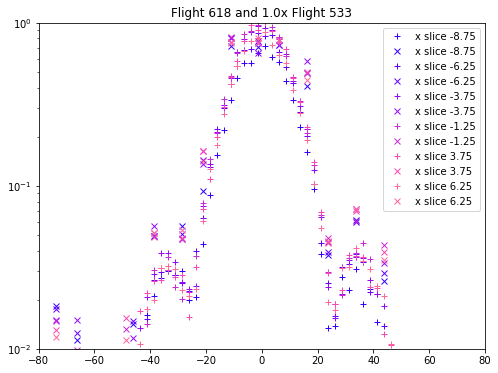

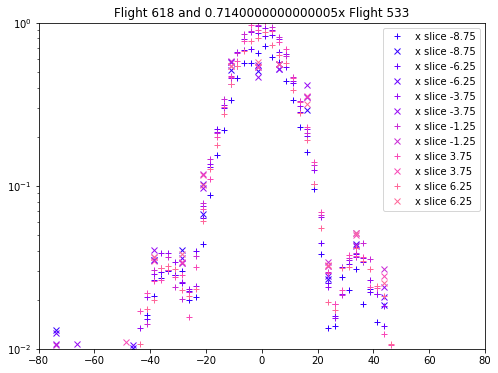

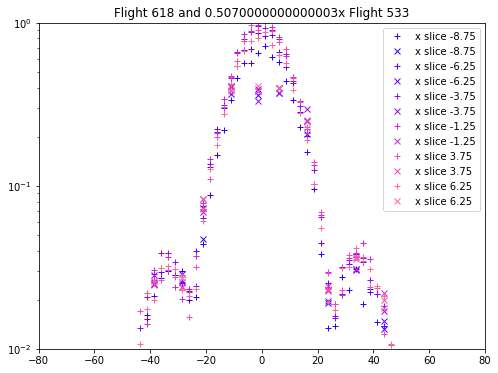

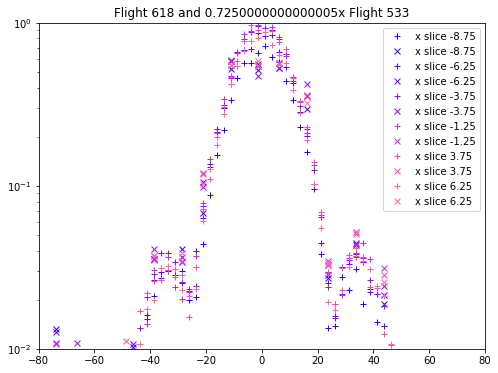

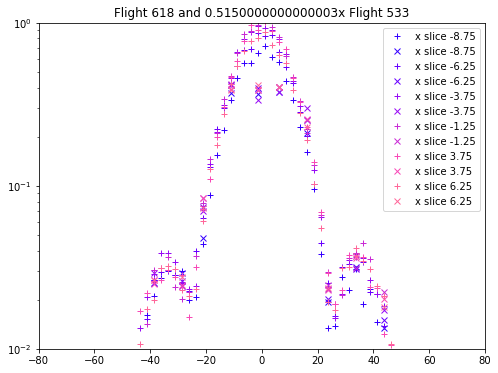

In [11]:
for n in [1.0, n_full, n_inner, n_outer, n_ann]:
    fl1 = beam2.V_LC_mean[:,:,f_intern,chind,0] 
    fl2 = n*beam1.V_LC_mean[:,:,f_intern,chind,0]
 
    fig = plt.figure(figsize=(8,6))
    for i,xx in enumerate(np.arange(-9,9,3)):
        colx = get_slice(beam1,beam1.V_LC_mean[:,:,f_intern,chind,0],xx,'x')
        plt.semilogy(beam1.y_centers_grid[:,colx,0],fl1[colx,:].T,'+',color=cmap(norm(xx)),
             label='x slice '+str(beam2.x_centers_grid[0,colx,0]))
        plt.semilogy(beam1.y_centers_grid[:,colx,0],fl2[colx,:].T,'x',color=cmap(norm(xx)),
             label='x slice '+str(beam2.x_centers_grid[0,colx,0]))
    plt.legend()
    plt.ylim(0.01,1)
    plt.xlim(-1*sz,sz)
    plt.title('Flight '+str(fly2)+' and '+str(n)+'x Flight '+str(fly1))
    plt.show()


In [12]:
## Look at sums with these normalizations - not visibly different, just use 1.0 for fun
#for n in [1.0]:
#    diffn = beam2.V_LC_mean[:,:,f_intern,chind,0] + n*beam1.V_LC_mean[:,:,f_intern,chind,0]
#
#    plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],
#               np.abs(diffn.T),cmap=cm.viridis,norm=LogNorm())
#    plt.colorbar()
#    plt.title('Flight '+str(fly2)+'+'+str(n)+'x Flight '+str(fly1))
#    plt.show()
#    
#
#    for i,xx in enumerate(np.arange(-25,30,10)):
#        colx = get_slice(beam1,diffn,xx,'x')
#        plt.semilogy(beam1.y_centers_grid[:,colx,0],diffn[colx,:].T,'o',color=cmap(norm(xx)),
#             label='x slice '+str(beam2.x_centers_grid[0,colx,0]))
#    plt.legend()
#    plt.title('Flight '+str(fly2)+'+'+str(n)+'x Flight '+str(fly1))
#    plt.show()
#
#    for i,xx in enumerate(np.arange(-25,25,10)):
#        coly = get_slice(beam1,diffn,xx,'y')
#        plt.semilogy(beam1.x_centers_grid[coly,:,0],diffn[:,coly].T,'o',color=cmap(norm(xx)),
#             label='y slice '+str(beam2.y_centers_grid[coly,0,0]))
#    plt.legend()
#    plt.title('Flight '+str(fly2)+'+'+str(n)+'x Flight '+str(fly1))
#    plt.show()

# TRy with interpolation instead

<ipython-input-13-9eff92ba7992>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],


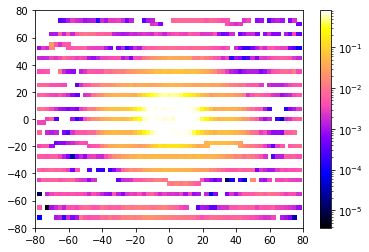

<ipython-input-13-9eff92ba7992>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],


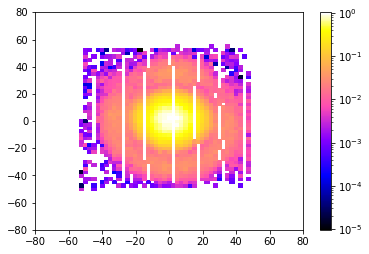

In [13]:
# Because the flights are in opposite directions, the overlap isn't that great. 
# We'll have to interpolate, let's do it to the same grid, but with no Nans
plt.pcolormesh(beam1.x_centers_grid[:,:,chind],beam1.y_centers_grid[:,:,chind],
               beam1.V_LC_operation[:,:,f_intern,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.colorbar()
plt.show()


plt.pcolormesh(beam2.x_centers_grid[:,:,chind],beam2.y_centers_grid[:,:,chind],
               beam2.V_LC_operation[:,:,f_intern,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.colorbar()
plt.show()


<ipython-input-14-5abfd86dc91c>:12: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX, LY, 10*np.log10(beam1_interp),


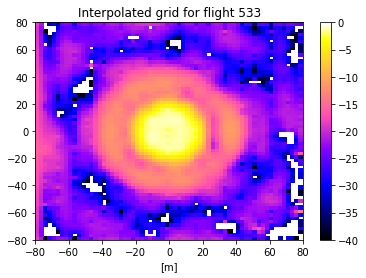

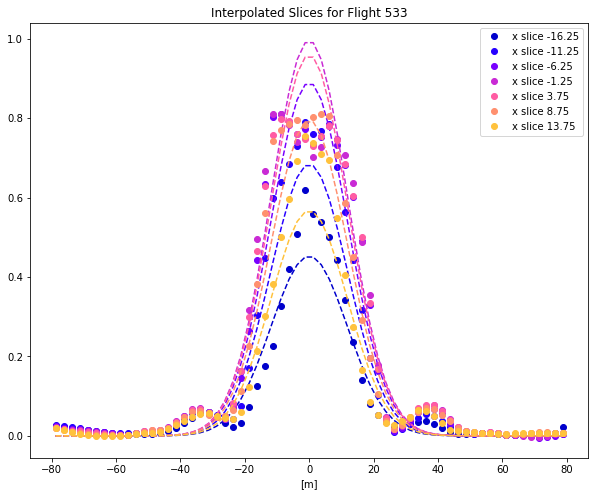

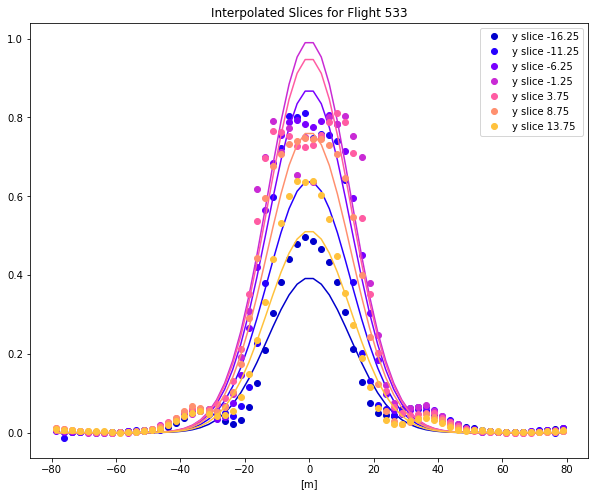

In [14]:
nonans1 = np.isfinite(beam1.V_LC_operation[:,:,f_intern,chind])

amp_corr = beam1.V_LC_operation[nonans1,f_intern,chind]
xp = beam1.x_centers_grid[nonans1,chind]
yp = beam1.y_centers_grid[nonans1,chind]
LX = beam1.x_centers_grid[:,:,chind]
LY = beam1.y_centers_grid[:,:,chind]
beam1_interp = griddata((xp,yp), amp_corr, (LX,LY), method='linear')
OK = OrdinaryKriging(xp,yp,amp_corr,variogram_model='spherical')
beam1_interp,ss = OK.execute("grid",LX[0,:],LY[:,0])

plt.pcolormesh(LX, LY, 10*np.log10(beam1_interp), 
               shading='auto', cmap='gnuplot2',vmin=-40,vmax=0)
plt.colorbar()
plt.title('Interpolated grid for flight '+str(fly1))
plt.xlabel('[m]')
plt.xlabel('[m]')
fig = plt.gcf()
fig.savefig('Flight_'+str(fly1)+'_interpolated_map.png')
plt.show()

fit = Gauss_2D_fromgrid(beam1,concattest1,find,chind)
#plt.pcolormesh(LX[:,:],LY[:,:],10*np.log10(fit))
#plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    colx = get_slice_anyin(LX,LY,xx,'x')
    plt.plot(LY[:,colx],beam1_interp[colx,:].T,'o',color=cmap(norm(xx)),label='x slice '+str(LX[0,colx]))
    plt.plot(LY[:,colx],fit[:,colx],color=cmap(norm(xx)),linestyle='--')#,label='x slice '+str(xx))
plt.legend()
plt.title('Interpolated Slices for Flight '+str(fly1))
plt.xlabel('[m]')
fig = plt.gcf()
fig.savefig('Flight_'+str(fly1)+'_interp_xslices.png')
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    coly = get_slice_anyin(LX,LY,xx,'y')
    plt.plot(LX[coly,:],beam1_interp[:,coly].T,'o',color=cmap(norm(xx)),label='y slice '+str(LY[coly,0]))
    plt.plot(LX[coly,:],fit[coly,:],color=cmap(norm(xx)))#,label='y slice '+str(xx))
plt.legend()
plt.title('Interpolated Slices for Flight '+str(fly1))
plt.xlabel('[m]')
fig = plt.gcf()
fig.savefig('Flight_'+str(fly1)+'_interp_yslices.png')
plt.show()




<ipython-input-15-f4dda250a966>:18: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX, LY, 10*np.log10(beam2_interp),


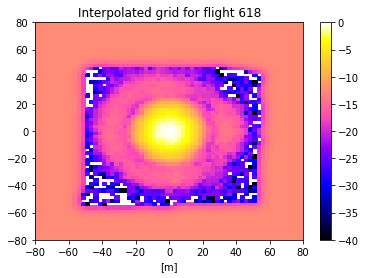

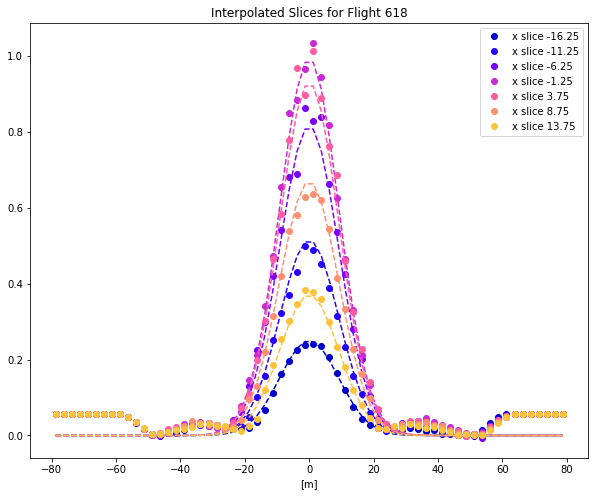

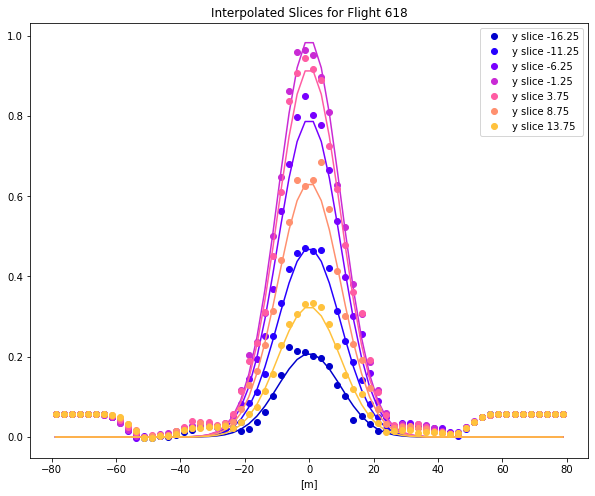

In [15]:
nonans2 = np.isfinite(beam2.V_LC_operation[:,:,f_intern,chind])

amp_corr = beam2.V_LC_operation[nonans2,f_intern,chind]
xp = beam2.x_centers_grid[nonans2,chind]
yp = beam2.y_centers_grid[nonans2,chind]
LX = beam2.x_centers_grid[:,:,chind]
LY = beam2.y_centers_grid[:,:,chind]
#beam2_interp = griddata((xp,yp), amp_corr, (LX,LY), method='linear')

#plt.pcolormesh(LX, LY, 10*np.log10(beam2_interp), 
#               shading='auto', cmap='gnuplot2',vmin=-40,vmax=0)
#plt.colorbar()
#plt.show()

OK = OrdinaryKriging(xp,yp,amp_corr,variogram_model='spherical')
beam2_interp,ss = OK.execute("grid",LX[0,:],LY[:,0])

plt.pcolormesh(LX, LY, 10*np.log10(beam2_interp), 
               shading='auto', cmap='gnuplot2',vmin=-40,vmax=0)
plt.colorbar()
plt.title('Interpolated grid for flight '+str(fly2))
plt.xlabel('[m]')
plt.xlabel('[m]')
fig = plt.gcf()
fig.savefig('Flight_'+str(fly2)+'_interpolated_map.png')
plt.show()

fit = Gauss_2D_fromgrid(beam2,concattest2,find,chind)
#plt.pcolormesh(LX[:,:],LY[:,:],10*np.log10(fit))
#plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    colx = get_slice_anyin(LX,LY,xx,'x')
    plt.plot(LY[:,colx],beam2_interp[colx,:].T,'o',color=cmap(norm(xx)),label='x slice '+str(LX[0,colx]))
    plt.plot(LY[:,colx],fit[:,colx],color=cmap(norm(xx)),linestyle='--')#,label='x slice '+str(xx))
plt.legend()
plt.title('Interpolated Slices for Flight '+str(fly2))
plt.xlabel('[m]')
fig = plt.gcf()
fig.savefig('Flight_'+str(fly2)+'_interp_xslices.png')
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    coly = get_slice_anyin(LX,LY,xx,'y')
    plt.plot(LX[coly,:],beam2_interp[:,coly].T,'o',color=cmap(norm(xx)),label='y slice '+str(LY[coly,0]))
    plt.plot(LX[coly,:],fit[coly,:],color=cmap(norm(xx)))#,label='y slice '+str(xx))
plt.legend()
plt.title('Interpolated Slices for Flight '+str(fly2))
plt.xlabel('[m]')
fig = plt.gcf()
fig.savefig('Flight_'+str(fly2)+'_interp_yslices.png')
plt.show()

<ipython-input-16-9f472204f713>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX,LY,np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')


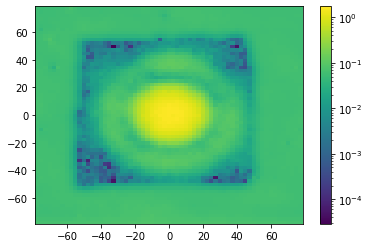

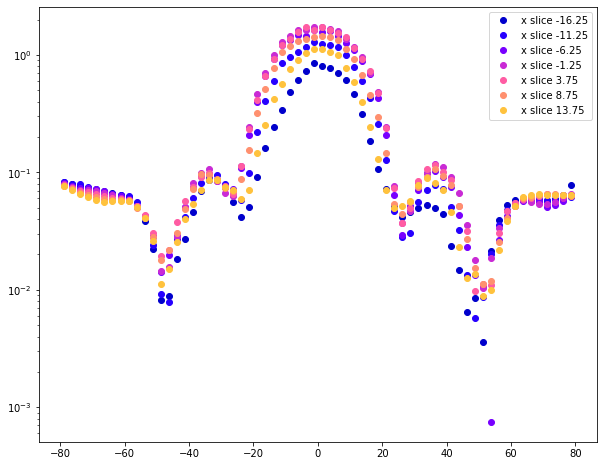

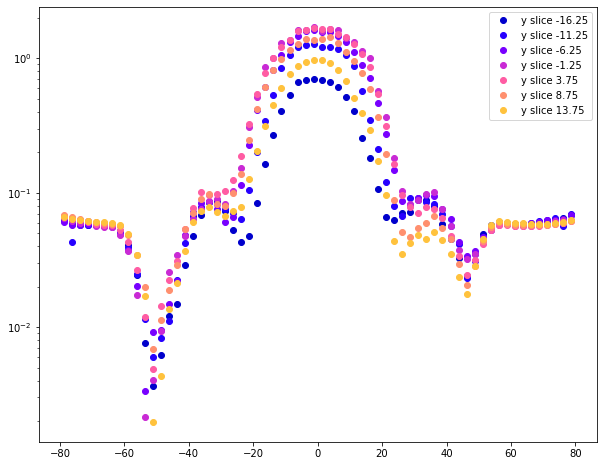

In [16]:
# look at sums
diff = beam2_interp[:,:] + beam1_interp[:,:]

plt.pcolormesh(LX,LY,np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
#plt.xlim(-50,50)
#plt.ylim(-50,50)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    colx = get_slice_anyin(LX,LY,xx,'x')
    plt.semilogy(LY[:,colx],diff[colx,:].T,'o',color=cmap(norm(xx)),label='x slice '+str(LX[0,colx]))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    coly = get_slice_anyin(LX,LY,xx,'y')
    plt.semilogy(LX[coly,:],diff[:,coly].T,'o',color=cmap(norm(xx)),label='y slice '+str(LY[coly,0]))
plt.legend()
plt.show()

<ipython-input-17-8fe9c9643079>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX,LY,diff.T,vmin = -0.1, vmax = 0.1,cmap=cm.viridis)#,edgecolors='k')


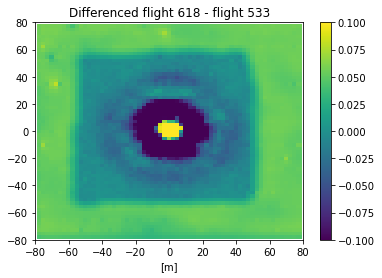

<ipython-input-17-8fe9c9643079>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')


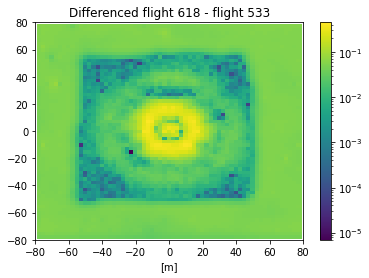

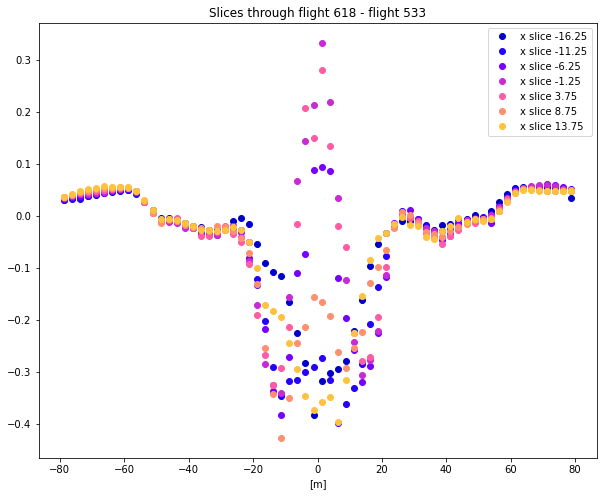

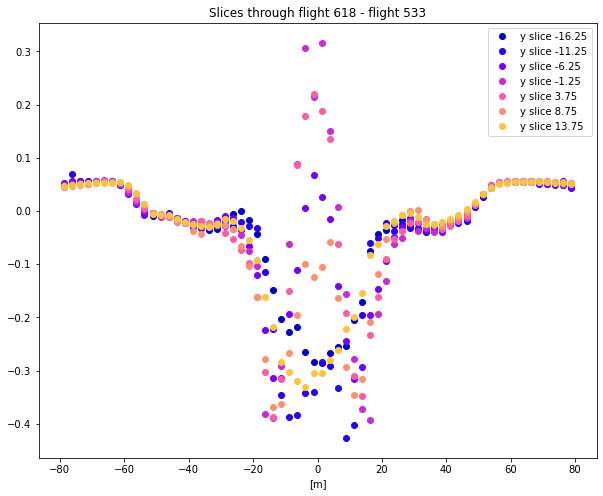

In [17]:
# look at differences
diff = get_beam_diff(beam2_interp[:,:], beam1_interp[:,:],1.0)

plt.pcolormesh(LX,LY,diff.T,vmin = -0.1, vmax = 0.1,cmap=cm.viridis)#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.colorbar()
plt.title('Differenced flight '+str(fly2)+' - flight '+str(fly1))
plt.xlabel('[m]')
plt.xlabel('[m]')
plt.show()

plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
plt.xlim(-1*sz,sz)
plt.ylim(-1*sz,sz)
plt.colorbar()
plt.title('Differenced flight '+str(fly2)+' - flight '+str(fly1))
plt.xlabel('[m]')
plt.xlabel('[m]')
plt.show()


fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    colx = get_slice_anyin(LX,LY,xx,'x')
    plt.plot(LY[:,colx],diff[colx,:].T,'o',color=cmap(norm(xx)),label='x slice '+str(LX[0,colx]))
plt.legend()
plt.title('Slices through flight '+str(fly2)+' - flight '+str(fly1))
plt.xlabel('[m]')
plt.xlabel('[m]')
plt.show()

fig = plt.figure(figsize=(10,8))
for i,xx in enumerate(np.arange(-15,16,5)):
    coly = get_slice_anyin(LX,LY,xx,'y')
    plt.plot(LX[coly,:],diff[:,coly].T,'o',color=cmap(norm(xx)),label='y slice '+str(LY[coly,0]))
plt.legend()
plt.title('Slices through flight '+str(fly2)+' - flight '+str(fly1))
plt.xlabel('[m]')
plt.xlabel('[m]')
plt.show()

<ipython-input-18-c503dafd532e>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')


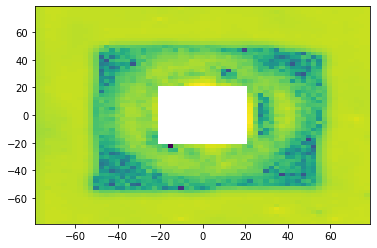

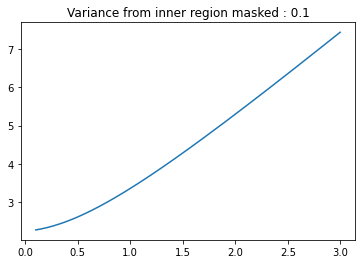

<ipython-input-18-c503dafd532e>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')


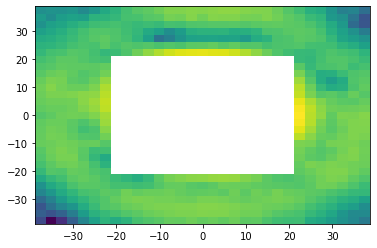

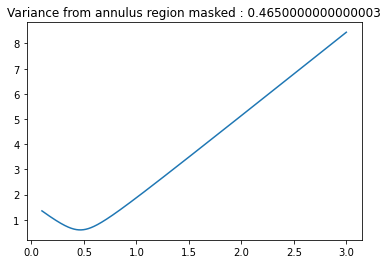

Best norm from variance with inner region masked: 0.1
Best norm from variance with annulus region masked: 0.4650000000000003


In [18]:
# Use same masks as we used for the data above to directly compare


# Mask everything inside of a region:
diff = get_beam_diff(beam2_interp[:,:], beam1_interp[:,:],1.0)

## Mask everything inside of various regions
# mask inner 

new_x = np.ma.masked_where(inner_mask, LX[:,:])
new_y = np.ma.masked_where(inner_mask, LY[:,:])
new_d = np.ma.masked_where(inner_mask, diff.T)

plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')
plt.show()

# Repeat --- scale the masked array and see if we can minimize residuals:

std100 = np.zeros([len(nss)])
for i in np.arange(0,len(nss)):
    ns = nss[i]
    diffn = diff = get_beam_diff(beam2_interp[:,:], beam1_interp[:,:],ns)
    new_d = np.ma.masked_where(inner_mask, diffn)
    diff_flat = np.ndarray.flatten(new_d)
    std100[i] = 100*np.nanstd(diff_flat)
mm = np.argmin(std100)
n_inner = nss[mm]
plt.plot(nss,std100)
plt.title('Variance from inner region masked : '+str(n_inner))
plt.show()

new_x = np.ma.masked_where(full_mask, LX[:,:])
new_y = np.ma.masked_where(full_mask, LY[:,:])
new_d = np.ma.masked_where(full_mask, diff)

plt.pcolor(new_x,new_y, np.abs(new_d.T),norm=LogNorm())#,edgecolors='k')
plt.show()


std100 = np.zeros([len(nss)])

for i in np.arange(0,len(nss)):
    ns = nss[i]
    diffn = diff = get_beam_diff(beam2_interp[:,:], beam1_interp[:,:],ns)
    new_d = np.ma.masked_where(full_mask, diffn)
    diff_flat = np.ndarray.flatten(new_d)
    std100[i] = 100*np.nanstd(diff_flat)
mm = np.argmin(std100)
n_ann = nss[mm]

plt.plot(nss,std100)
plt.title('Variance from annulus region masked : '+str(n_ann))
plt.show()


print('Best norm from variance with inner region masked: '+str(n_inner))
print('Best norm from variance with annulus region masked: '+str(n_ann))

<ipython-input-19-00706dbd1490>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX[:,:],LY[:,:],diff.T,cmap=cm.viridis,vmin=-0.1,vmax=0.1)#,edgecolors='k')


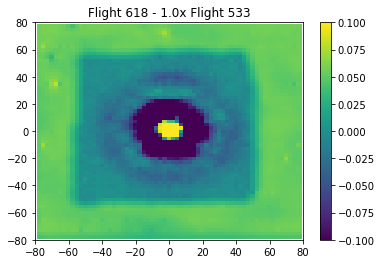

<ipython-input-19-00706dbd1490>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,
<ipython-input-19-00706dbd1490>:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,


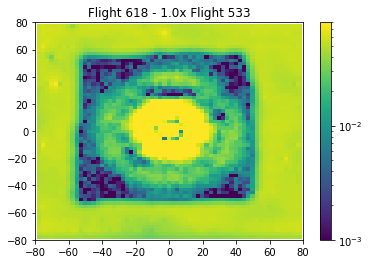

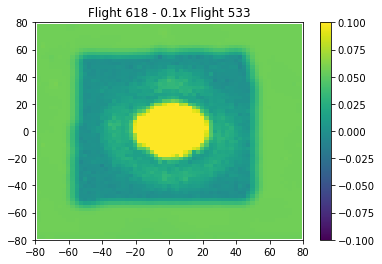

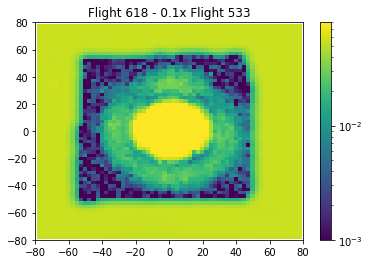

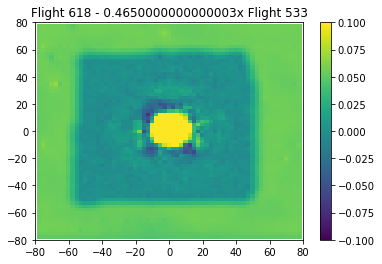

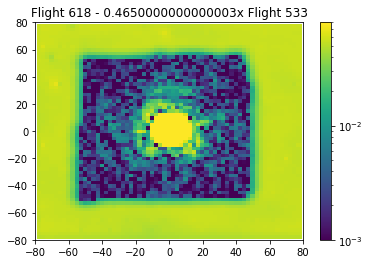

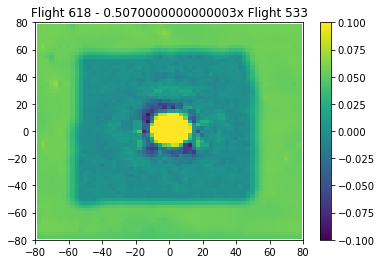

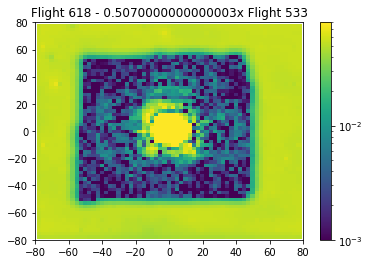

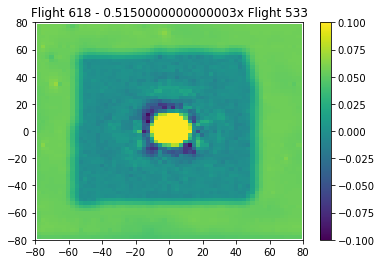

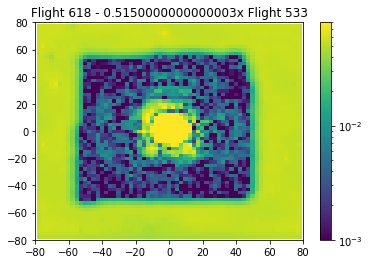

In [19]:
for n in [1.0, n_inner,n_ann,n_inner_data,n_ann_data]:
    diff = diff = get_beam_diff(beam2_interp[:,:], beam1_interp[:,:],n)

    plt.pcolormesh(LX[:,:],LY[:,:],diff.T,cmap=cm.viridis,vmin=-0.1,vmax=0.1)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.colorbar()
    plt.title('Flight '+str(fly2)+' - '+str(n)+'x Flight '+str(fly1))
    plt.show()
    
    plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,
                   vmin=0.001,vmax=0.08,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.colorbar()
    plt.title('Flight '+str(fly2)+' - '+str(n)+'x Flight '+str(fly1))
    fig = plt.gcf()
    fig.savefig('Flight_'+str(fly2)+'-'+str(n)+'xFlight'+str(fly1)+'_map.png')
    plt.show()
    
    
    

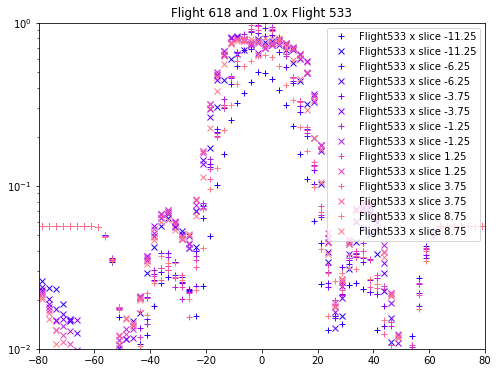

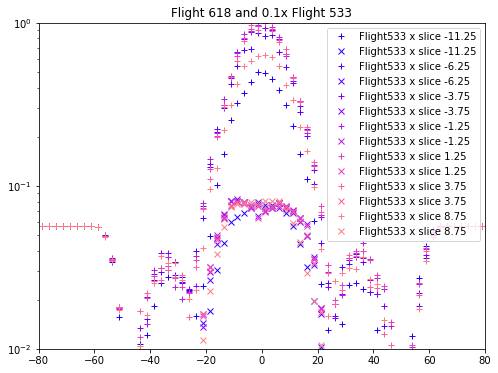

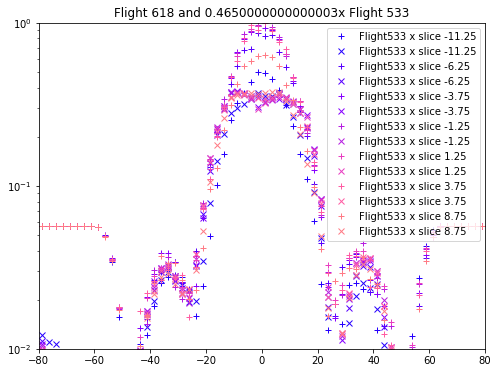

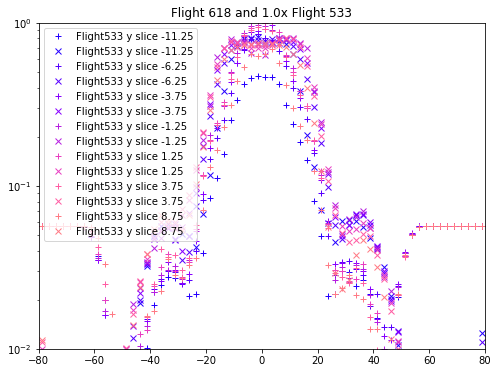

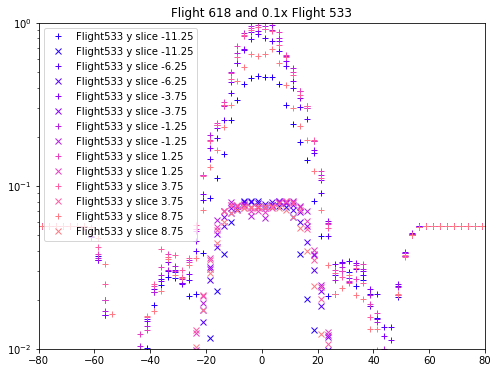

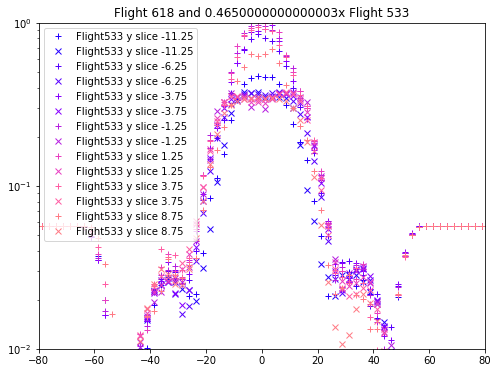

In [20]:
for n in [1.0, n_inner,n_ann]:
    fl1 = beam2_interp[:,:] 
    fl2 = n*beam1_interp[:,:]
 
    fig = plt.figure(figsize=(8,6))
    for i,xx in enumerate(np.arange(-1*sliw,sliw,3)):
        colx = get_slice_anyin(LX,LY,xx,'x')
        plt.semilogy(LY[:,colx],fl1[colx,:].T,'+',color=cmap(norm(xx)),
             label='Flight'+str(fly1)+' x slice '+str(LX[0,colx]))
        plt.semilogy(LY[:,colx],fl2[colx,:].T,'x',color=cmap(norm(xx)),
             label='Flight'+str(fly1)+' x slice '+str(LX[0,colx]))
    plt.legend()
    plt.ylim(0.01,1)
    plt.xlim(-1*sz,sz)
    plt.title('Flight '+str(fly2)+' and '+str(n)+'x Flight '+str(fly1))
    fig = plt.gcf()
    fig.savefig('Flight_'+str(fly2)+'_'+str(n)+'xFlight'+str(fly1)+'_overlayslice.png')
    plt.show()

for n in [1.0, n_inner,n_ann]:
    fl1 = beam2_interp[:,:] 
    fl2 = n*beam1_interp[:,:]
 
    fig = plt.figure(figsize=(8,6))
    for i,xx in enumerate(np.arange(-1*sliw,sliw,3)):
        coly = get_slice_anyin(LX,LY,xx,'y')
        plt.semilogy(LX[coly,:],fl1[:,coly].T,'+',color=cmap(norm(xx)),
             label='Flight'+str(fly1)+' y slice '+str(LY[coly,0]))
        plt.semilogy(LX[coly,:],fl2[:,coly].T,'x',color=cmap(norm(xx)),
             label='Flight'+str(fly1)+' y slice '+str(LY[coly,0]))
    plt.legend()
    plt.ylim(0.01,1)
    plt.xlim(-1*sz,sz)
    plt.title('Flight '+str(fly2)+' and '+str(n)+'x Flight '+str(fly1))
    fig = plt.gcf()
    fig.savefig('Flight_'+str(fly2)+'_'+str(n)+'xFlight'+str(fly1)+'_overlayslice.png')
    plt.show()

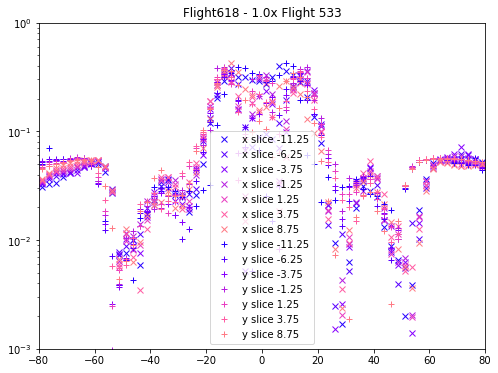

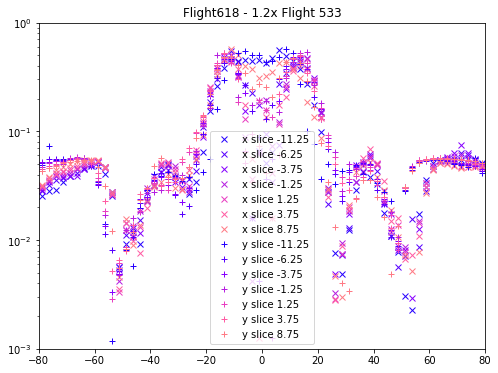

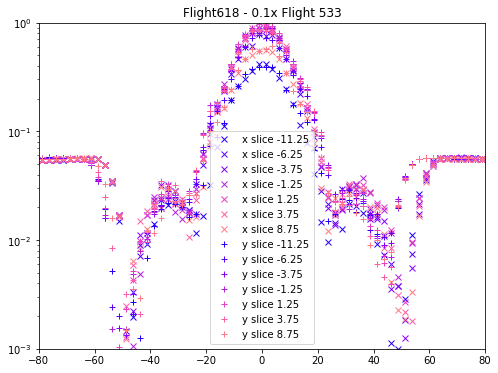

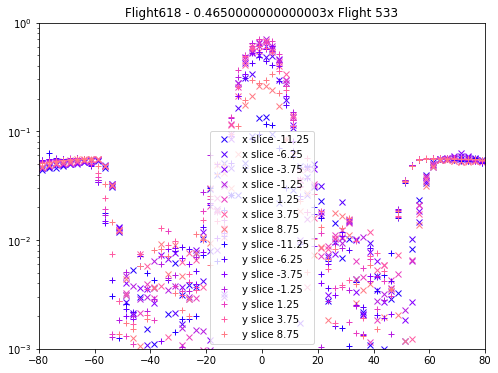

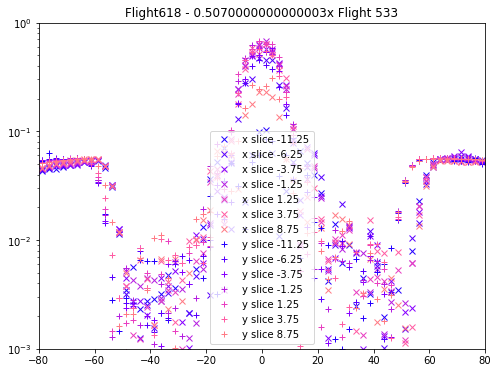

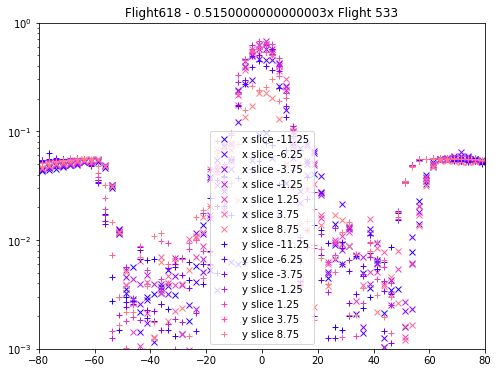

In [21]:
for n in [1.0, n_inner,n_ann,n_inner_data,n_ann_data]:
    diff = get_beam_diff(beam2_interp[:,:], beam1_interp[:,:],n)
    
    fig = plt.figure(figsize=(8,6))
    for i,xx in enumerate(np.arange(-1*sliw,sliw,3)):
        colx = get_slice_anyin(LX,LY,xx,'x')
        plt.semilogy(LY[:,colx],np.abs(diff[colx,:]).T,'x',color=cmap(norm(xx)),
             label='x slice '+str(LX[0,colx]))
    for i,xx in enumerate(np.arange(-1*sliw,sliw,3)):
        coly = get_slice_anyin(LX,LY,xx,'y')
        plt.semilogy(LX[coly,:],np.abs(diff[:,coly]).T,'+',color=cmap(norm(xx)),
             label='y slice '+str(LY[coly,0]))
    plt.legend()
    plt.ylim(0.001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Flight'+str(fly2)+' - '+str(n)+'x Flight '+str(fly1))
    fig = plt.gcf()
    fig.savefig('Flight_'+str(fly2)+'-'+str(n)+'xFlight'+str(fly1)+'_allslices.png')
    plt.show()
    

In [22]:
print('Best norm from variance with inner region masked, data: '+str(n_inner_data))
print('Best norm from variance with annulus region masked, data: '+str(n_ann_data))
print('Best norm from variance with inner region masked, interp: '+str(n_inner))
print('Best norm from variance with annulus region masked, interp: '+str(n_ann))



Best norm from variance with inner region masked, data: 0.5070000000000003
Best norm from variance with annulus region masked, data: 0.5150000000000003
Best norm from variance with inner region masked, interp: 0.1
Best norm from variance with annulus region masked, interp: 0.4650000000000003


In [23]:
with open("Variancemins.txt", "a") as file:
    file.write('Flight 1 '+str(fly1)+' Flight 2 '+str(fly2)+' : '
               +' data inner mask '+str(n_inner_data)+' data annulus mask '+str(n_ann_data)
               +' interp inner mask '+str(n_inner)+' interp annulus mask '+ str(n_ann)+'\n')


<ipython-input-24-c67eaf0cb281>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')


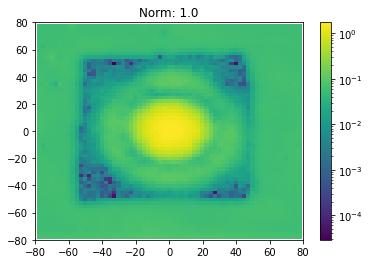

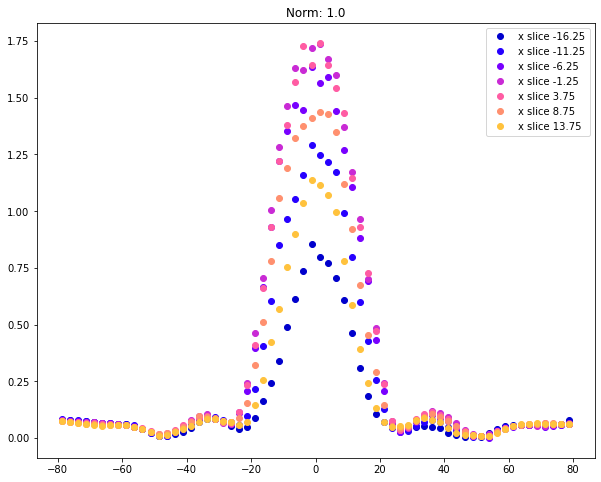

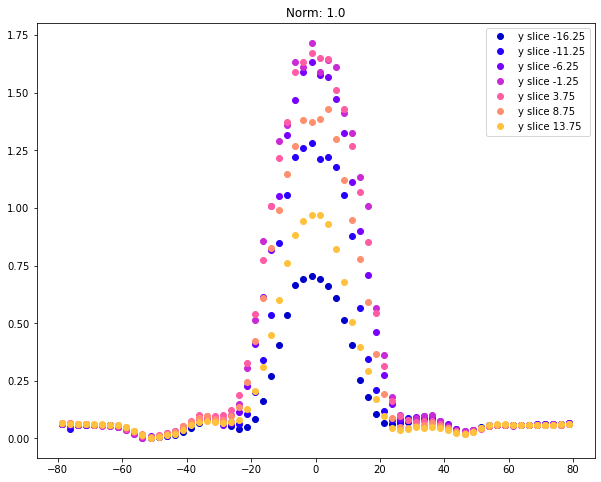

<ipython-input-24-c67eaf0cb281>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')


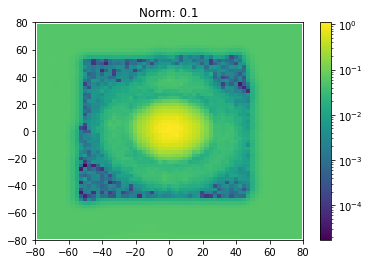

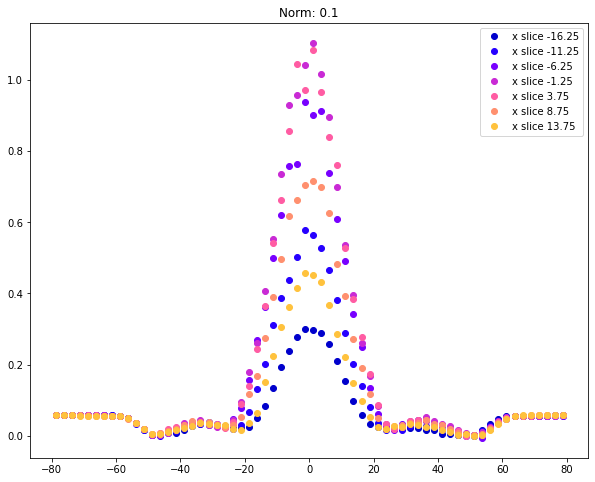

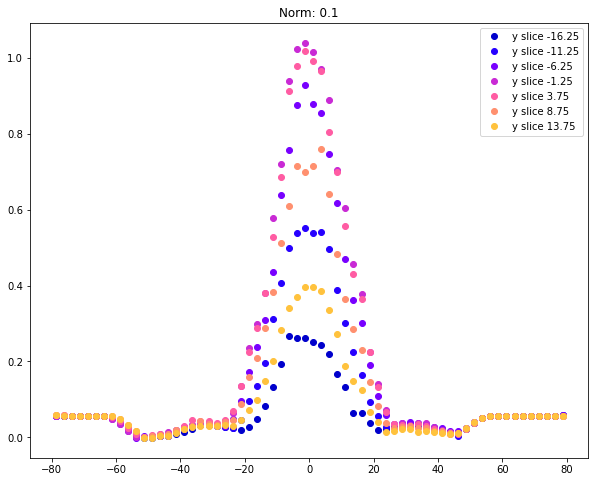

<ipython-input-24-c67eaf0cb281>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')


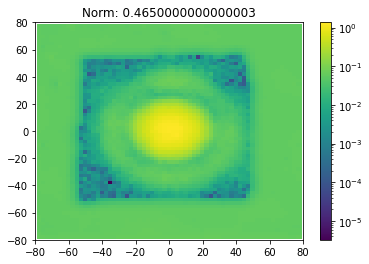

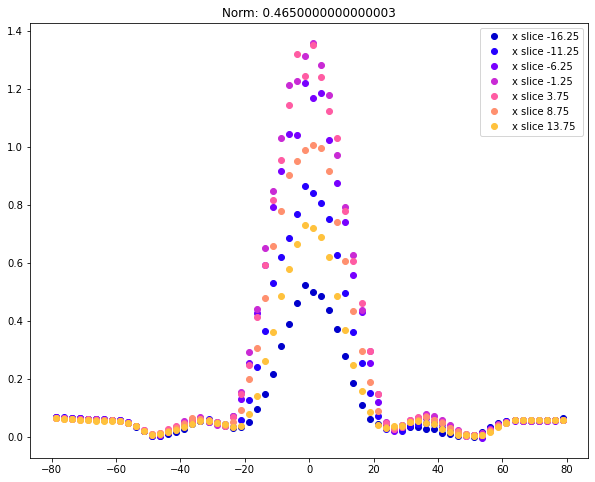

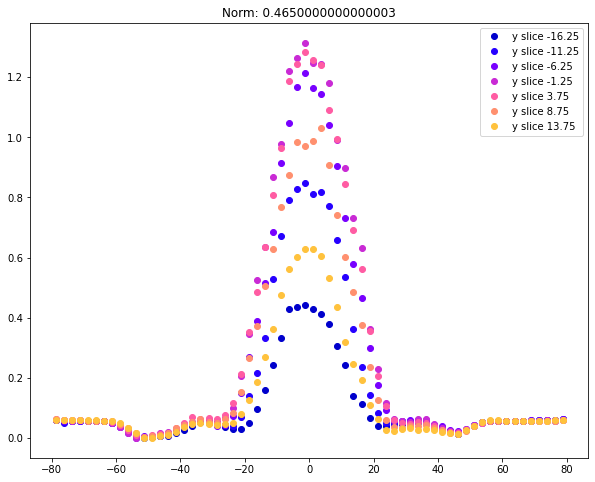

In [24]:
# look at sums
for n in [1.0, n_inner,n_ann]:
    diff = beam2_interp[:,:] + n*beam1_interp[:,:]


    plt.pcolormesh(LX[:,:],LY[:,:],np.abs(diff.T),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.colorbar()
    plt.title('Norm: '+str(n))
    plt.show()


    fig = plt.figure(figsize=(10,8))
    for i,xx in enumerate(np.arange(-15,16,5)):
        colx = get_slice_anyin(LX,LY,xx,'x')
        plt.plot(LY[:,colx],diff[colx,:].T,'o',color=cmap(norm(xx)),label='x slice '+str(LX[0,colx]))
    plt.legend()
    plt.title('Norm: '+str(n))
    plt.show()

    fig = plt.figure(figsize=(10,8))
    for i,xx in enumerate(np.arange(-15,16,5)):
        coly = get_slice_anyin(LX,LY,xx,'y')
        plt.plot(LX[coly,:],diff[:,coly].T,'o',color=cmap(norm(xx)),label='y slice '+str(LY[coly,0]))
    plt.legend()
    plt.title('Norm: '+str(n))
    plt.show()

In [25]:
#def get_newpointing(x,y,xc,yx,theta):
#    xp = x - xc
#    yp = y - yc
#    xpp = np.cos(theta)*xp - np.sin(theta)*yp
#    ypp = np.sin(theta)*xp + np.cos(theta)*yp
#    return xpp, ypp
#
#def get_slice(x,y,ty,val,tol):
#    if ty=='x':
#        ni = np.where(np.abs(x-val)<=tol)
#    if ty=='y':
#        ni = np.where(np.abs(y-val)<=tol)
#    return ni

#def radial_profile(x,y,z,x0,y0):
#    r = np.sqrt((x-x0)**2 + (y-y0)**2)
#    r = r.astype(np.int)
#
#    tbin = np.bincount(r.ravel(), z.ravel())
#    nr = np.bincount(r.ravel())
#    radialprofile = tbin / nr
#    return radialprofile 